# Clean up data

Let's take a look at what the data from the flight computer looks like. This data was recorded by an Arduino, logging telemetry once per second from the GPS and various sensors sensors and recorded them once a second.  More details and the source code of the flight computer can be located at https://github.com/sea7aero/horizon2.

In [3]:
import numpy as np
import pandas as pd

directory = '../data/'

# Some data recorded at the time of flight
launch_time = "TODO"
payload_weight_g = 1325.0 # TODO
balloon_weight_g = 1200.0

# The flight tracker records invalid values as "*", so we want to replace those with Not a Number (NaN).
data = pd.read_csv(directory + '/raw-data.csv', na_values="*")
data.head()

,millis,year,month,day,hour,minute,second,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH,Unnamed: 19
0,1544,NaN,NaN,NaN,NaN,NaN,NaN,4.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.31,93891.82,638.10,42.74,NaN
1,2546,2000.0,0.0,0.0,0.0,0.0,0.0,4.37,0.0,99.99,NaN,NaN,NaN,NaN,NaN,19.36,93894.09,637.90,43.11,NaN
2,3547,2000.0,0.0,0.0,0.0,0.0,0.0,4.40,0.0,99.99,NaN,NaN,NaN,NaN,NaN,19.38,93892.00,638.09,42.69,NaN
3,4550,2000.0,0.0,0.0,0.0,0.0,0.0,4.40,0.0,99.99,NaN,NaN,NaN,NaN,NaN,19.39,93899.64,637.41,42.37,NaN
4,5551,2000.0,0.0,0.0,0.0,0.0,0.0,4.40,0.0,99.99,NaN,NaN,NaN,NaN,NaN,19.41,93896.39,637.70,42.41,NaN


The raw data is a bit noisy - especially the first dozen seconds or so before the GPS acquired its lock - so the first step is to clean up the invalid data and a few other transformations in order to make it easier to work with.

In [15]:
# The tracker stores each part of the timestamp in a different column. To make it easier for us to work with and
# graph, we convert those columns into a single timestamp column, and make it the index of the Pandas dataframe.
datetime_cols = ["year", "month", "day", "hour", "minute", "second"]
timestamps = data[datetime_cols].apply(lambda x: "{:.0f}-{:.0f}-{:.0f} {:.0f}:{:.0f}:{:.0f}".format(*x), axis=1)
data["timestamp"] = pd.to_datetime(timestamps, errors="coerce")
data.drop(datetime_cols, axis=1)

# The first few rows don't have a valid timestamp at all; we'll just get rid of them.
data = data[data["timestamp"].notnull()]
data.index = data["timestamp"]
data = data.drop(["timestamp"], axis=1)

# # Fill any missing data with the last known value.  Then backfill missing data at the beginning of the file.
data = data.ffill().bfill()

# # Removes the extraneous "unnamed" column.
data = data.dropna(how="all", axis=1)

data.head()

,millis,year,month,day,hour,minute,second,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH
timestamp,,,,,,,,,,,,,,,,,,,
2021-09-25 17:26:17,21594,2021.0,9.0,25.0,17.0,26.0,17.0,4.40,0.0,99.99,656.1,0.0,0.1,47.160809,-120.84832,19.56,93893.46,637.96,42.33
2021-09-25 17:26:18,22598,2021.0,9.0,25.0,17.0,26.0,18.0,4.40,0.0,99.99,656.1,0.0,0.1,47.160809,-120.84832,19.56,93896.89,637.65,42.08
2021-09-25 17:26:19,23600,2021.0,9.0,25.0,17.0,26.0,19.0,4.37,0.0,99.99,656.1,0.0,0.1,47.160809,-120.84832,19.58,93898.86,637.48,41.96
2021-09-25 17:26:20,24604,2021.0,9.0,25.0,17.0,26.0,20.0,4.40,0.0,99.99,656.1,0.0,0.1,47.160809,-120.84832,19.59,93894.25,637.89,42.06
2021-09-25 17:26:21,25607,2021.0,9.0,25.0,17.0,26.0,21.0,4.40,0.0,99.99,656.1,0.0,0.1,47.160809,-120.84832,19.59,93891.08,638.17,42.25


That's much better, but we turned the tracker on almost an hour before launch, and that data is kind of boring, so let us compute some interesting time spans and crop our data to just the mission data.

In [16]:
launch_index = np.argmax(data['gps_altitude_m'].diff() > 5) # TODO, index this off the GoPro data.
launch_millis = data['millis'][launch_index]
launch_time = data.index[launch_index]
data['mission_millis'] = data['millis'] - launch_millis

burst_index = np.argmax(data['gps_altitude_m'])
burst_time = data.index[burst_index]
landing_time = data.index[-1]

print("Launch Time (UTC) : {}".format(launch_time))
print("Burst Time        : {}".format(burst_time))
print("Landing Time      : {}".format(landing_time))

ascent_duration = burst_time - launch_time
descent_duration = landing_time - burst_time
mission_duration = ascent_duration + descent_duration

print("Mission Duration  : {}".format(mission_duration))
print("Ascent Duration   : {}".format(ascent_duration))
print("Descent Duration  : {}".format(descent_duration))

Launch Time (UTC) : 2021-09-25 17:28:51
Burst Time        : 2021-09-25 20:04:25
Landing Time      : 2021-09-25 20:41:37
Mission Duration  : 0 days 03:12:46
Ascent Duration   : 0 days 02:35:34
Descent Duration  : 0 days 00:37:12


In [17]:
mission_data = data[data['mission_millis'] >= 0]
mission_data.head()

,millis,year,month,day,hour,minute,second,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH,mission_millis
timestamp,,,,,,,,,,,,,,,,,,,,
2021-09-25 17:28:51,175147,2021.0,9.0,25.0,17.0,28.0,51.0,4.34,8.0,1.04,688.1,156.1,3.0,47.160690,-120.848381,20.94,93470.10,675.52,36.10,0
2021-09-25 17:28:52,176153,2021.0,9.0,25.0,17.0,28.0,52.0,4.40,8.0,1.04,692.1,156.1,2.1,47.160686,-120.848351,20.90,93424.56,679.56,36.20,1006
2021-09-25 17:28:53,177154,2021.0,9.0,25.0,17.0,28.0,53.0,4.43,7.0,1.22,695.1,147.0,4.0,47.160698,-120.848312,20.84,93372.32,684.21,36.27,2007
2021-09-25 17:28:54,178156,2021.0,9.0,25.0,17.0,28.0,54.0,4.40,8.0,1.04,699.8,114.2,2.3,47.160706,-120.848267,20.74,93324.85,688.43,36.50,3009
2021-09-25 17:28:55,179162,2021.0,9.0,25.0,17.0,28.0,55.0,4.40,8.0,1.04,705.2,95.5,2.8,47.160702,-120.848236,20.66,93273.02,693.05,36.56,4015


The very observant may notice a problem in the data above... It turns out, I made a bit of a mistake in the code.  I log the data twice a second although the GPS only updates once per second.  This results in the GPS data being duplicated, which makes analysis a little more difficult.

The easiest fix is to just remove every other row.

# Data analysis

Now that the data is cleaned up, we can start to take a look at it and see what we can learn.  In addition to pretty graphs, we are also interested in learning how we can improve the next flight.  The following questions are particularly pressing:

1. Why did the balloon travel so far east of its predicted course?
1. Why did the balloon descend so fast - did the parachute work as designed?
1. Why did the camera - a GoPro Hero Black 9 - stop recording approximately 54 minutes into the flight?

In [18]:
# We start by setting up and formatting our graphs.
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_style("ticks")

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi']= 150

# Show ticks every 15 minutes.
locator = mdates.MinuteLocator(byminute=[0,15,30,45])
formatter = mdates.ConciseDateFormatter(locator)

def pretty_plots(nrows=1, ncols=1):
    fig, ax = plt.subplots(nrows, ncols, tight_layout=True)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    return ax

## Altitude

The first obvious thing to do is to plot the altitude and see what we get. In our case, we have 2 sources of data for the altitude: the value reported by the GPS and a value derived from the barometric pressure sensor.  Let's see what we've got...

Maximum altitude discrepency: 7005 meters


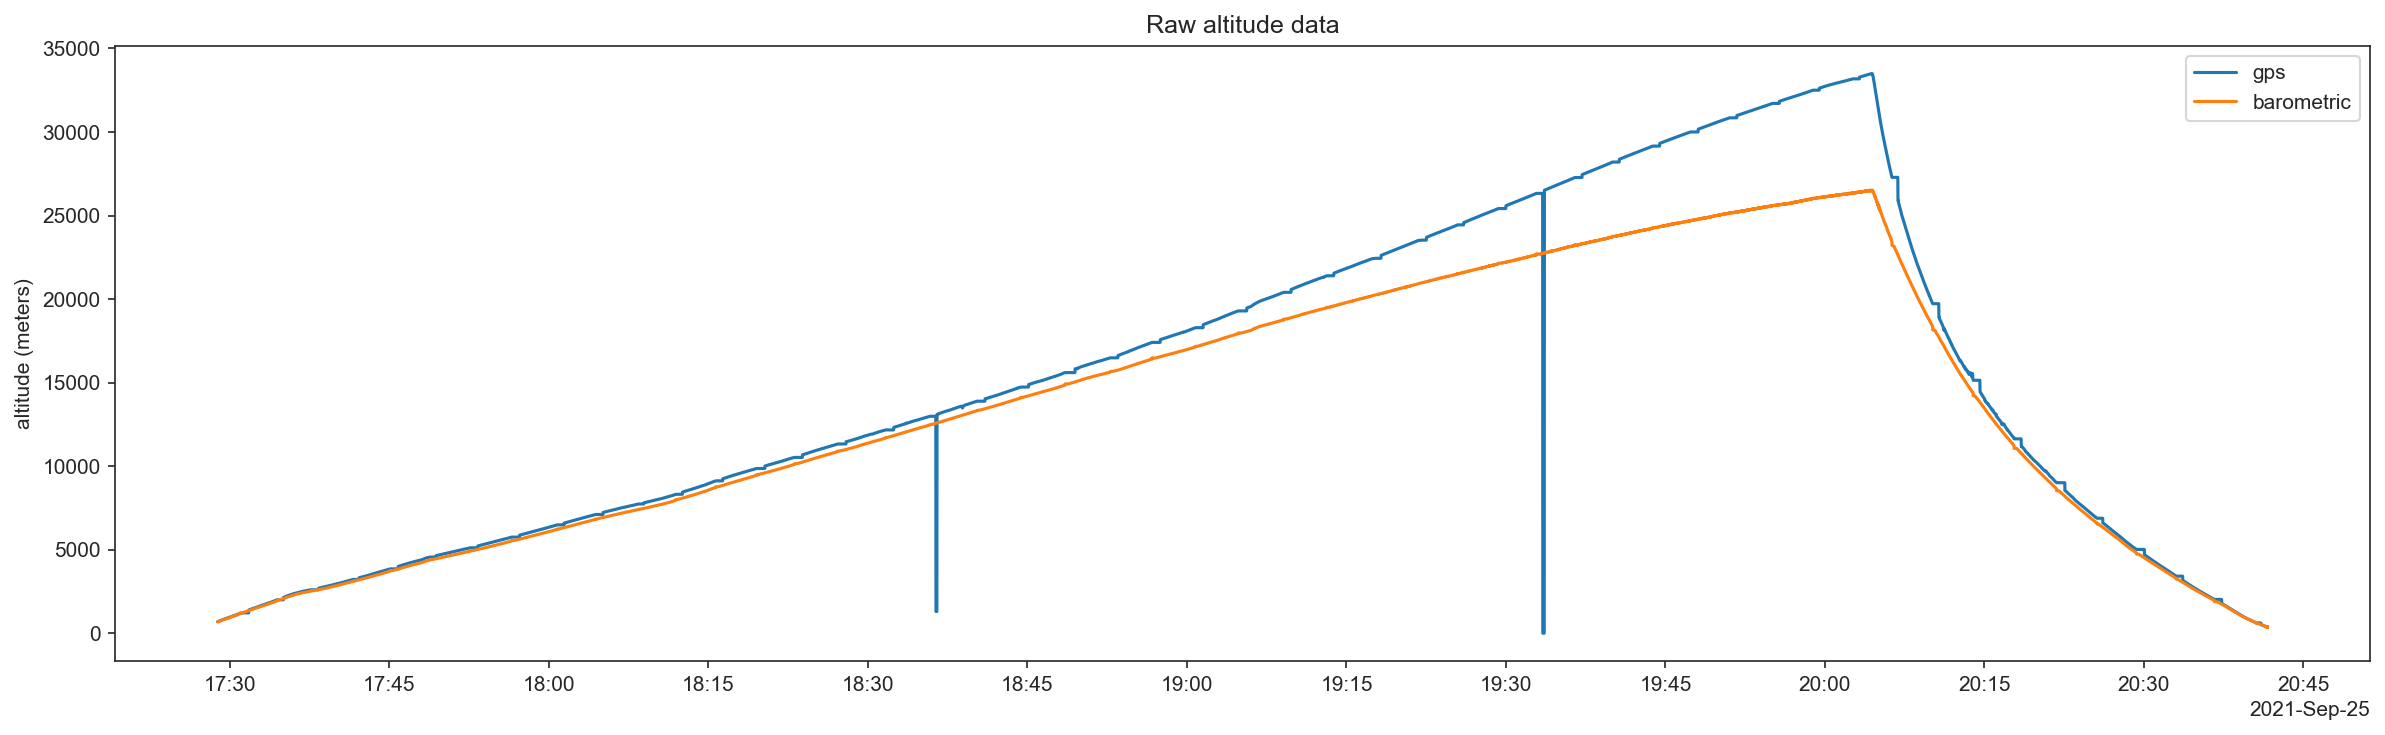

In [19]:
ax = pretty_plots()
ax.plot(mission_data[["gps_altitude_m", "pressure_altitude_m"]])
ax.set_ylabel("altitude (meters)")
ax.legend(["gps", "barometric"])
ax.set_title('Raw altitude data')

difference = (mission_data["gps_altitude_m"] - mission_data["pressure_altitude_m"]).max()
print(f"Maximum altitude discrepency: {difference:.0f} meters")

Hmm... already we see something is up. The altitude from our barometer starts to drift from the altitude from the GPS?  What's going on here?

We compute the altitude from the barometric pressure in `Sensors.cpp` as follows:

```
// Equation taken from BMP180 datasheet (page 16):
//  http://www.adafruit.com/datasheets/BST-BMP180-DS000-09.pdf

// Note that using the equation from wikipedia can give bad results
// at high altitude. See this thread for more information:
// http://forums.adafruit.com/viewtopic.php?f=22&t=58064

return 44330.0 * (1.0 - pow(atmosphericPressurePa / seaLevelPressurePa, 0.1903));
```

The comments give us a clue that something is up, and if we follow the links we find that the formula being used is derived from the [Barometric formula](https://en.wikipedia.org/wiki/Barometric_formula), solving for altitude above sea-level. The magic numbers being used are assumptions that are derived from the [U.S. Standard Atmosphere](https://en.wikipedia.org/wiki/U.S._Standard_Atmosphere), but these values are not the same in different layers of the atmosphere...

### Earth's Atmosphere

Our first problem is that the formula being used is only valid for the troposphere, and our balloon travelled through the troposphere, tropopause, and into the stratosphere!

So, let's correct that using a more accurate formula for altitude, which is described in good detail [in this article](https://www.translatorscafe.com/unit-converter/en-US/calculator/altitude/) and [here](https://www.mide.com/air-pressure-at-altitude-calculator) and using values from the [International Standard Atmosphere](https://en.wikipedia.org/wiki/International_Standard_Atmosphere), which is "recommended in the processing of data from geophysical and meteorological observations."

In [20]:
# Here, we're loading up the ISA atmopsheric conditions and defining some constants.
isa = pd.read_csv(directory + '/standard-atmosphere.csv', index_col="layer").sort_values('base_pressure_Pa')

def annotate_layers(ax, label=True, max_layer=10):
    for index, layer in isa.iterrows():
        if(index < max_layer):
            altitude=layer['geopotential_altitude_m']
            ax.axhline(altitude, color='black', ls='-.', lw=0.25)
            if(label):
                ax.text(0.01, altitude+400, layer['name'], transform=ax.get_yaxis_transform())
        
display(isa)

,name,geopotential_altitude_m,geometric_altitude_m,lapse_rate_K_m,base_temperature_C,base_temperature_K,base_pressure_Pa,base_density_kg_m3
layer,,,,,,,,
7,Mesopause,84852,86000,NaN,-86.28,186.87,0.37,NaN
6,Mesosphere,71000,71802,-0.0020,-58.50,214.65,3.96,NaN
5,Mesosphere,51000,51413,-0.0028,-2.50,270.65,66.94,NaN
4,Stratopause,47000,47350,0.0000,-2.50,270.65,110.91,0.0020
3,Stratosphere,32000,32162,0.0028,-44.50,228.65,868.02,0.0132
2,Stratosphere,20000,20063,0.0010,-56.50,216.65,5474.90,0.0880
1,Tropopause,11000,11019,0.0000,-56.50,216.65,22632.00,0.3639
0,Troposphere,-610,-611,-0.0065,19.00,292.15,108900.00,1.2985


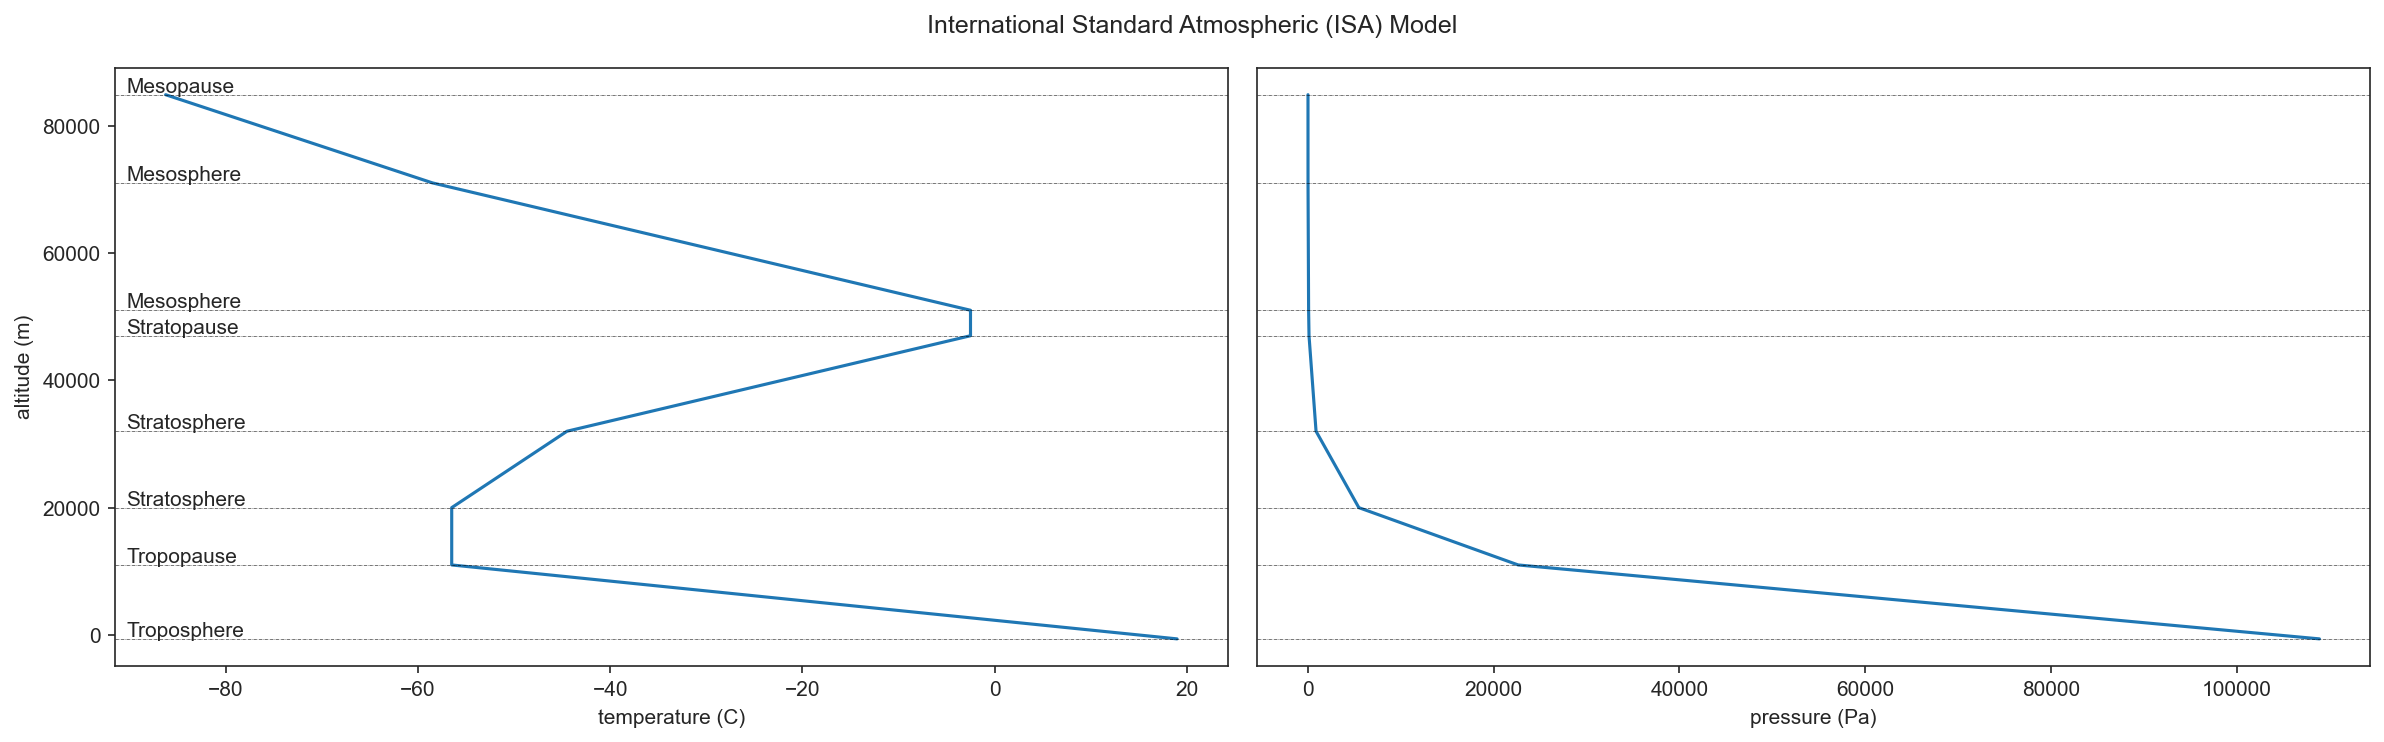

In [21]:
fig, axes = plt.subplots(1, 2, tight_layout=True)
fig.suptitle("International Standard Atmospheric (ISA) Model")

axes[0].plot(isa['base_temperature_C'], isa['geopotential_altitude_m'])
axes[0].set_ylabel("altitude (m)")
axes[0].set_xlabel("temperature (C)")

axes[1].plot(isa['base_pressure_Pa'], isa['geopotential_altitude_m'])
axes[1].yaxis.set_visible(False)
axes[1].set_xlabel("pressure (Pa)")


annotate_layers(axes[0])
annotate_layers(axes[1], False)

### A better formula

We can now use the values from the standard model to calculate the geopotential height, $H$, given a pressure reading, $P$.  There are two formulas, depending on whether the lapse rate, $L_b$ is zero or not.

\\[H=H_b + \frac{-R^*T_b\ln{(\frac{P}{P_b})}}{g_0M}\\]

\\[H=H_b + \frac{T_b}{L_b}\left[\left(\frac{P}{P_b}\right)^\frac{-R^*L_b}{g_0M}-1\right]\\]

In [22]:
import math

universal_gas_constant = 8.31432 # R, N*m/mol*K
molar_mass_dry_air = 0.0289644 # M, kg/mol
gas_constant_dry_air = universal_gas_constant / molar_mass_dry_air
gravitational_acceleration = 9.80665 # g0, m/s^2
# R / g0 * M
altitude_constants = -1.0 * gas_constant_dry_air / gravitational_acceleration

def calc_altitude(pressure):
    layer = isa['base_pressure_Pa'].searchsorted(pressure)
    parameters = isa.iloc[layer]
    base_altitude = parameters['geopotential_altitude_m']
    base_temperature = parameters['base_temperature_K']
    pressure_ratio = pressure / parameters['base_pressure_Pa']
    lapse_rate = parameters['lapse_rate_K_m']
    
    if lapse_rate == 0:
        factor = altitude_constants * base_temperature 
        return base_altitude + factor * math.log(pressure_ratio)
    else:
        factor = base_temperature / lapse_rate
        exponent = altitude_constants * lapse_rate
        return base_altitude + factor * (pow(pressure_ratio, exponent)-1)
    
calc_altitude = np.vectorize(calc_altitude)

/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/3813892522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mission_data['better_pressure_altitude_m'] = calc_altitude(mission_data['pressure_Pa'])


Maximum altitude discrepency: 1874 meters


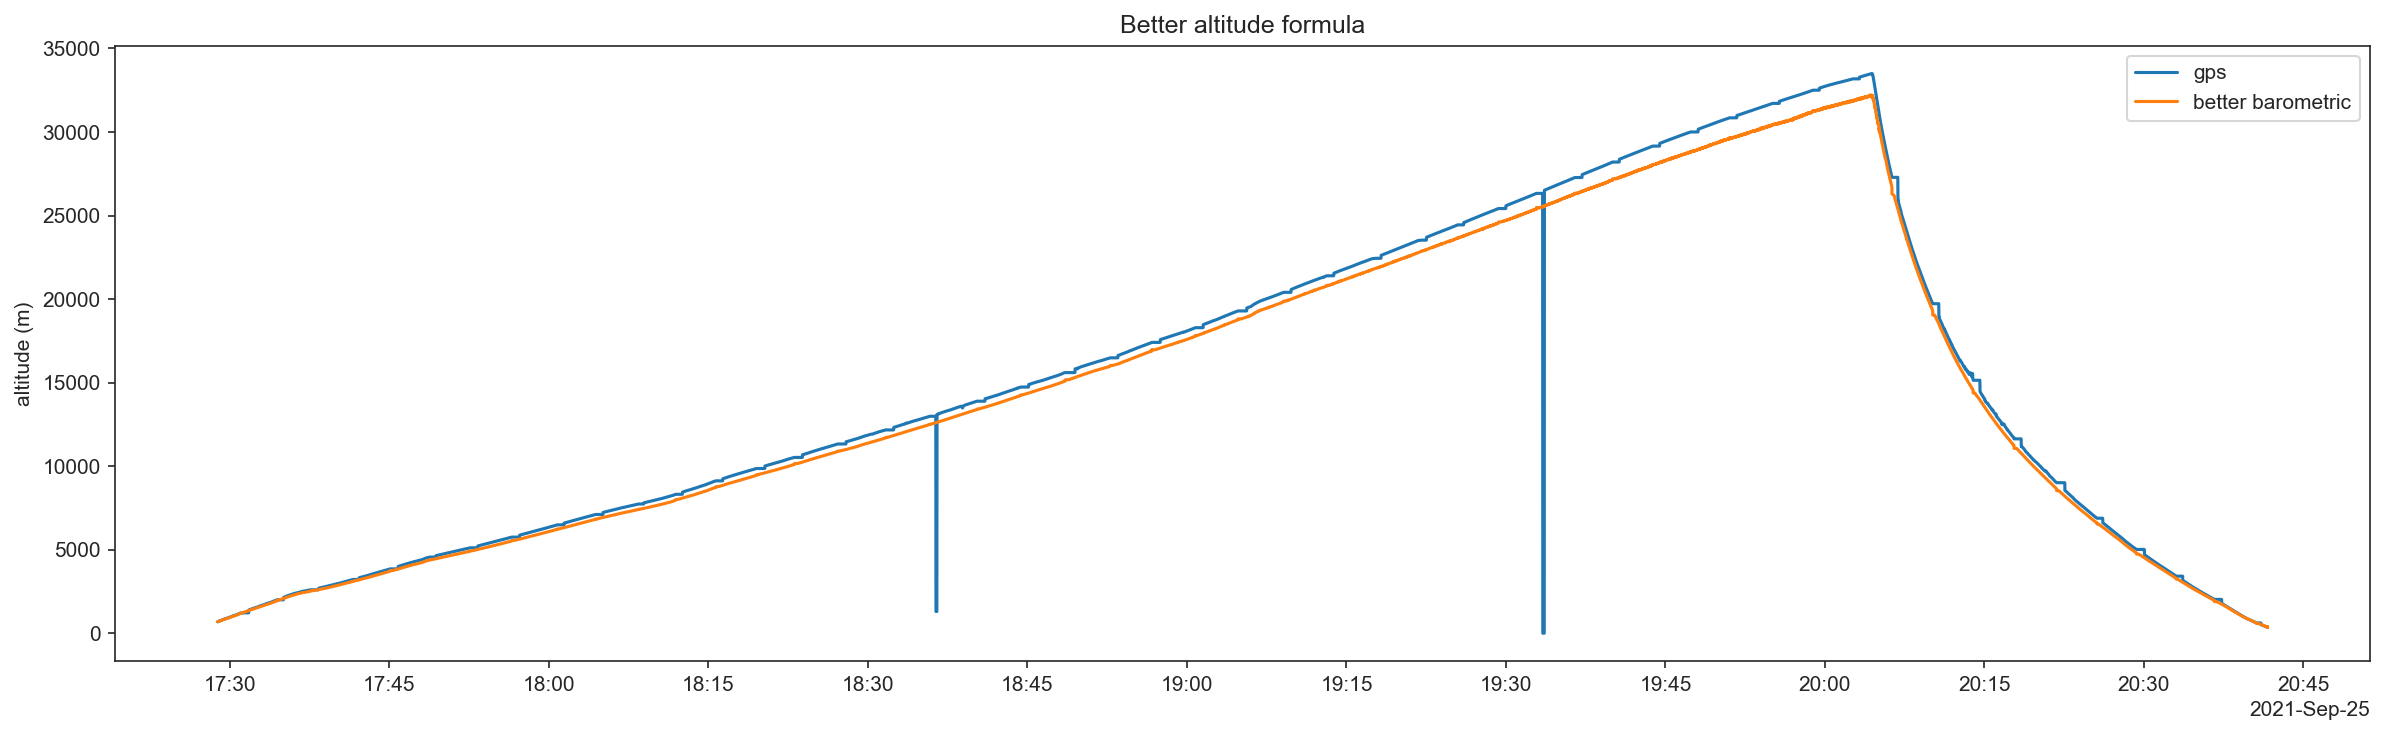

In [23]:
mission_data['better_pressure_altitude_m'] = calc_altitude(mission_data['pressure_Pa'])
ax = pretty_plots()
ax.plot(mission_data[['gps_altitude_m', 'better_pressure_altitude_m']])
ax.set_ylabel("altitude (m)")
ax.legend(["gps", "better barometric"])
ax.set_title("Better altitude formula")

difference = (mission_data["gps_altitude_m"] - mission_data["better_pressure_altitude_m"]).max()
print(f"Maximum altitude discrepency: {difference:.0f} meters")

### Temperature adjusted altitude

Still not great... we're off by 1,800 meters at burst.  So, what else could be going wrong.  Investigating further, I found that one can compensate for temperature in the formula for altitude by substiting the pressure ratio,  $\frac{P}{P_b}$ with a density ratio, $\frac{\rho}{\rho_b}$ using the following formula:

\\[\frac{\rho}{\rho_b}=\frac{P}{P_b}\cdot\frac{T_b}{T}\\]

What happens when we try this?

In [24]:
# From: https://commons.erau.edu/cgi/viewcontent.cgi?article=1124&context=ijaaa
def calc_altitude_temp_adjusted(pressure_Pa, temperature_C):
    temperature_K = temperature_C + 273.15
    layer = isa['base_pressure_Pa'].searchsorted(pressure_Pa)
    parameters = isa.iloc[layer]
    
    base_altitude_m = parameters['geopotential_altitude_m']
    base_temperature_K = parameters['base_temperature_K']
    temp_ratio = base_temperature_K / temperature_K
    
    pressure_ratio = pressure_Pa / parameters['base_pressure_Pa']
    
    density_ratio = pressure_ratio * temp_ratio
    lapse_rate = parameters['lapse_rate_K_m']
    
    if lapse_rate == 0:
        factor = altitude_constants * base_temperature_K
        return base_altitude_m + factor * math.log(density_ratio)
    else:
        factor = base_temperature_K / lapse_rate
        exponent = altitude_constants * lapse_rate
        return base_altitude_m + factor * (pow(density_ratio, exponent)-1)
    
calc_altitude_temp_adjusted = np.vectorize(calc_altitude_temp_adjusted)


/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/4073196593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mission_data['temp_adjusted_altitude_m'] = calc_altitude_temp_adjusted(mission_data['pressure_Pa'], mission_data['temperature_C'])


Maximum altitude discrepency: 2632 meters


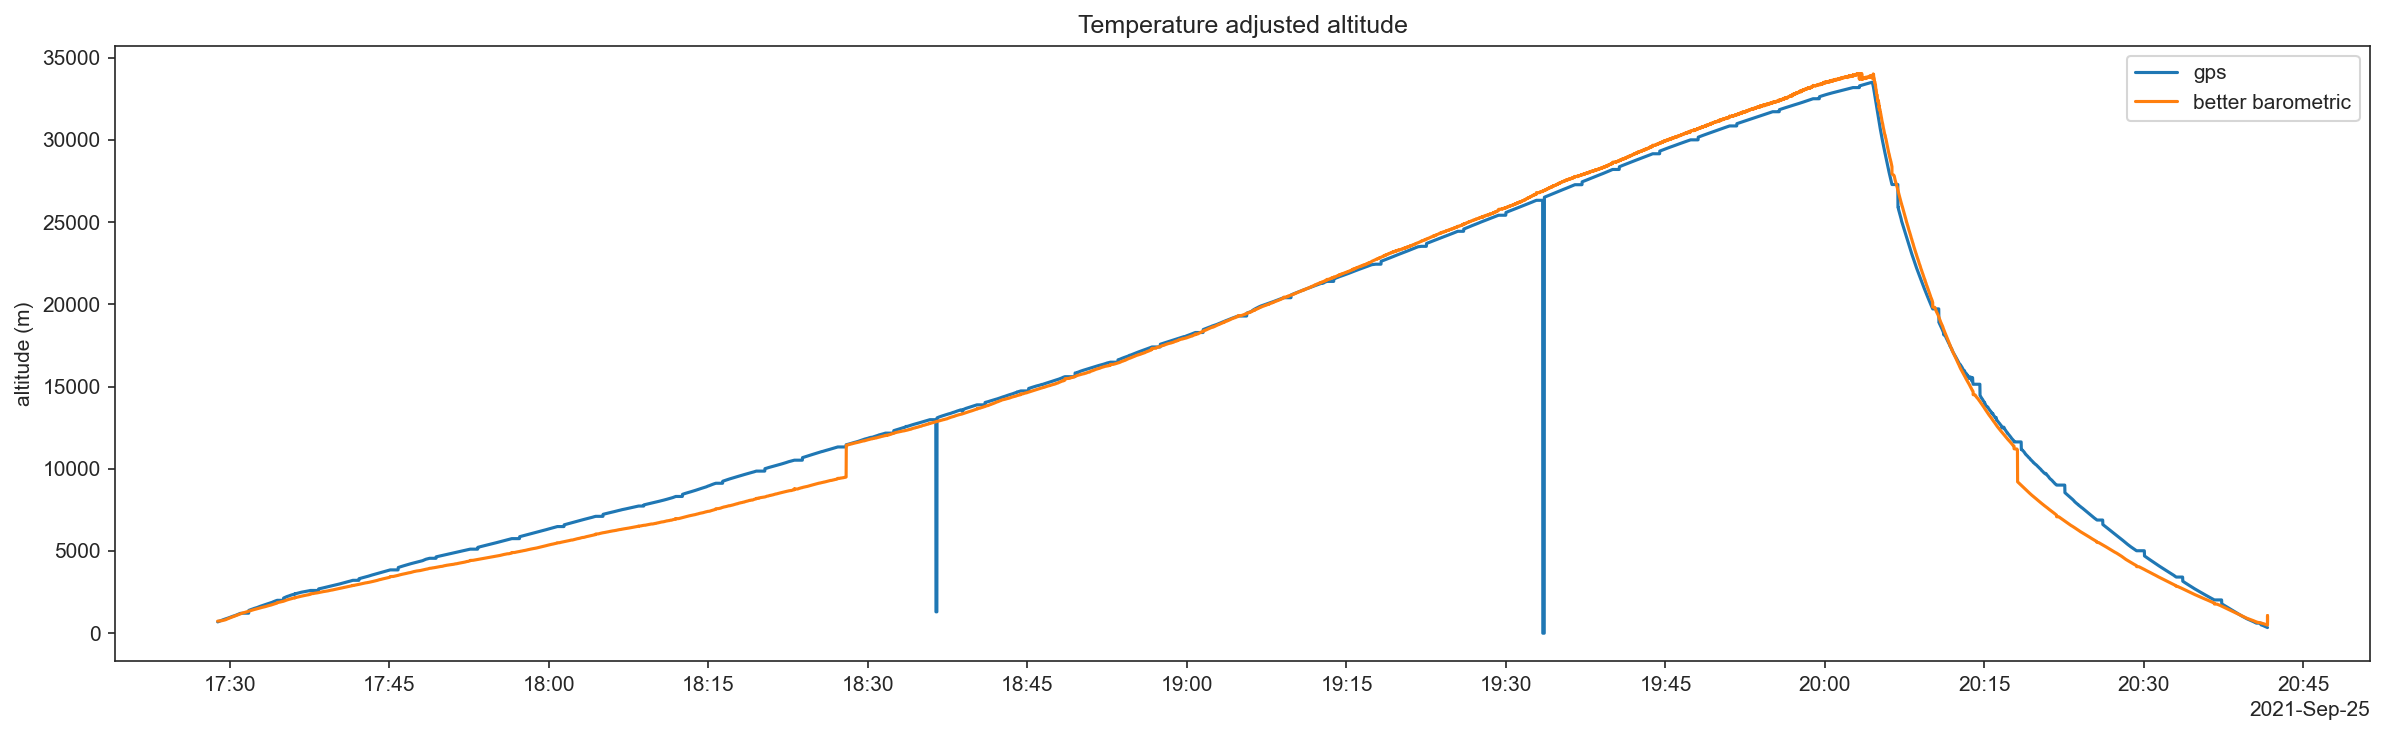

In [25]:
mission_data['temp_adjusted_altitude_m'] = calc_altitude_temp_adjusted(mission_data['pressure_Pa'], mission_data['temperature_C'])
ax = pretty_plots()
ax.plot(mission_data[['gps_altitude_m', 'temp_adjusted_altitude_m']])
ax.set_ylabel("altitude (m)")
ax.legend(["gps", "better barometric"]);
ax.set_title("Temperature adjusted altitude")

difference = mission_data["gps_altitude_m"] - mission_data["temp_adjusted_altitude_m"]
print(f"Maximum altitude discrepency: {difference.max():.0f} meters")

### Sensor problems

Okay, this is worse than we started!  I had to dig pretty deep through the source code of various libraries I'm using, but what I think is going on is that the sensor we are using is already adjusting for temperatures within it's normal operating range (under 30,000 Pa) and so, by trying to compensate the altitude with the temperature, I am making things worse.

Couple that with a discovery that the temperature reading above the tropopause is completely off from the standard model, and I think this explains the discrepency.

**Lesson learned:** next time I'm going to record the raw, uncompensated, data from the sensor. Also, I should try to get my hands on a sensor accurate within our expected flying conditions!

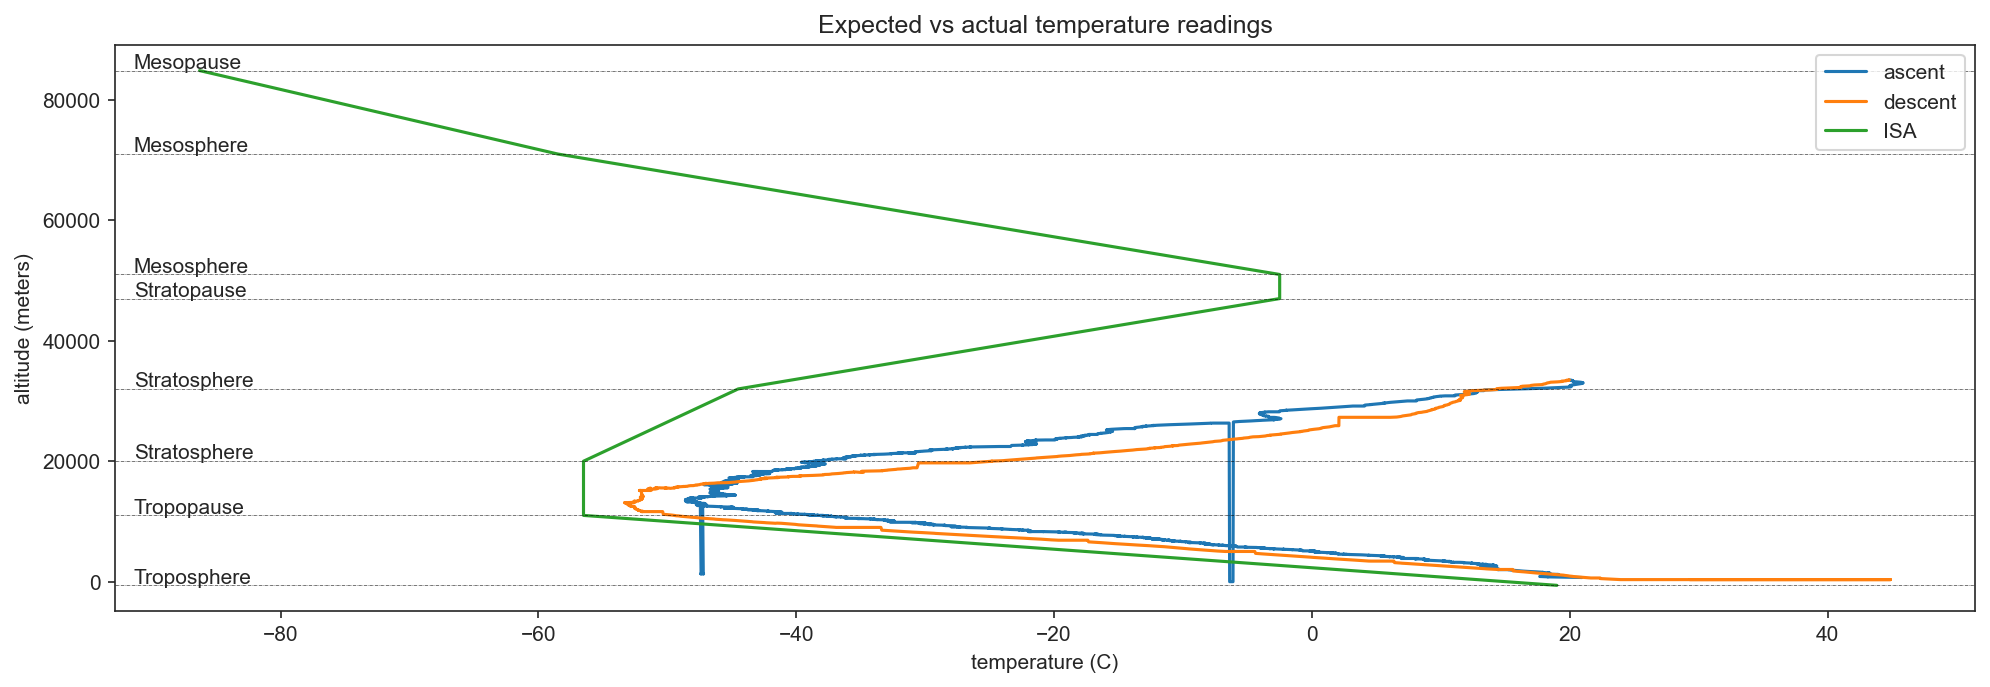

In [26]:
ascent_data = mission_data[mission_data.index < burst_time]
descent_data = mission_data[mission_data.index > burst_time]

fig, ax = plt.subplots()

ax.plot(ascent_data['temperature_C'], ascent_data['gps_altitude_m'], label="ascent")
ax.plot(descent_data['temperature_C'], descent_data['gps_altitude_m'], label="descent")
ax.plot(isa['base_temperature_C'], isa['geopotential_altitude_m'], label="ISA")

ax.set_title("Expected vs actual temperature readings")
ax.set_ylabel("altitude (meters)")
ax.set_xlabel("temperature (C)")
annotate_layers(ax)
ax.legend();

In [29]:
def calc_altitude_blended(pressure_Pa, temperature_C):
    if(pressure_Pa > 22632):
        return calc_altitude(pressure_Pa)
    else:
        return calc_altitude_temp_adjusted(pressure_Pa, temperature_C)
    
calc_altitude_blended = np.vectorize(calc_altitude_blended)

/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/139312134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mission_data['blended_altitude_m'] = calc_altitude_blended(mission_data['pressure_Pa'], mission_data['temperature_C'])


Maximum altitude discrepency: 1046 meters


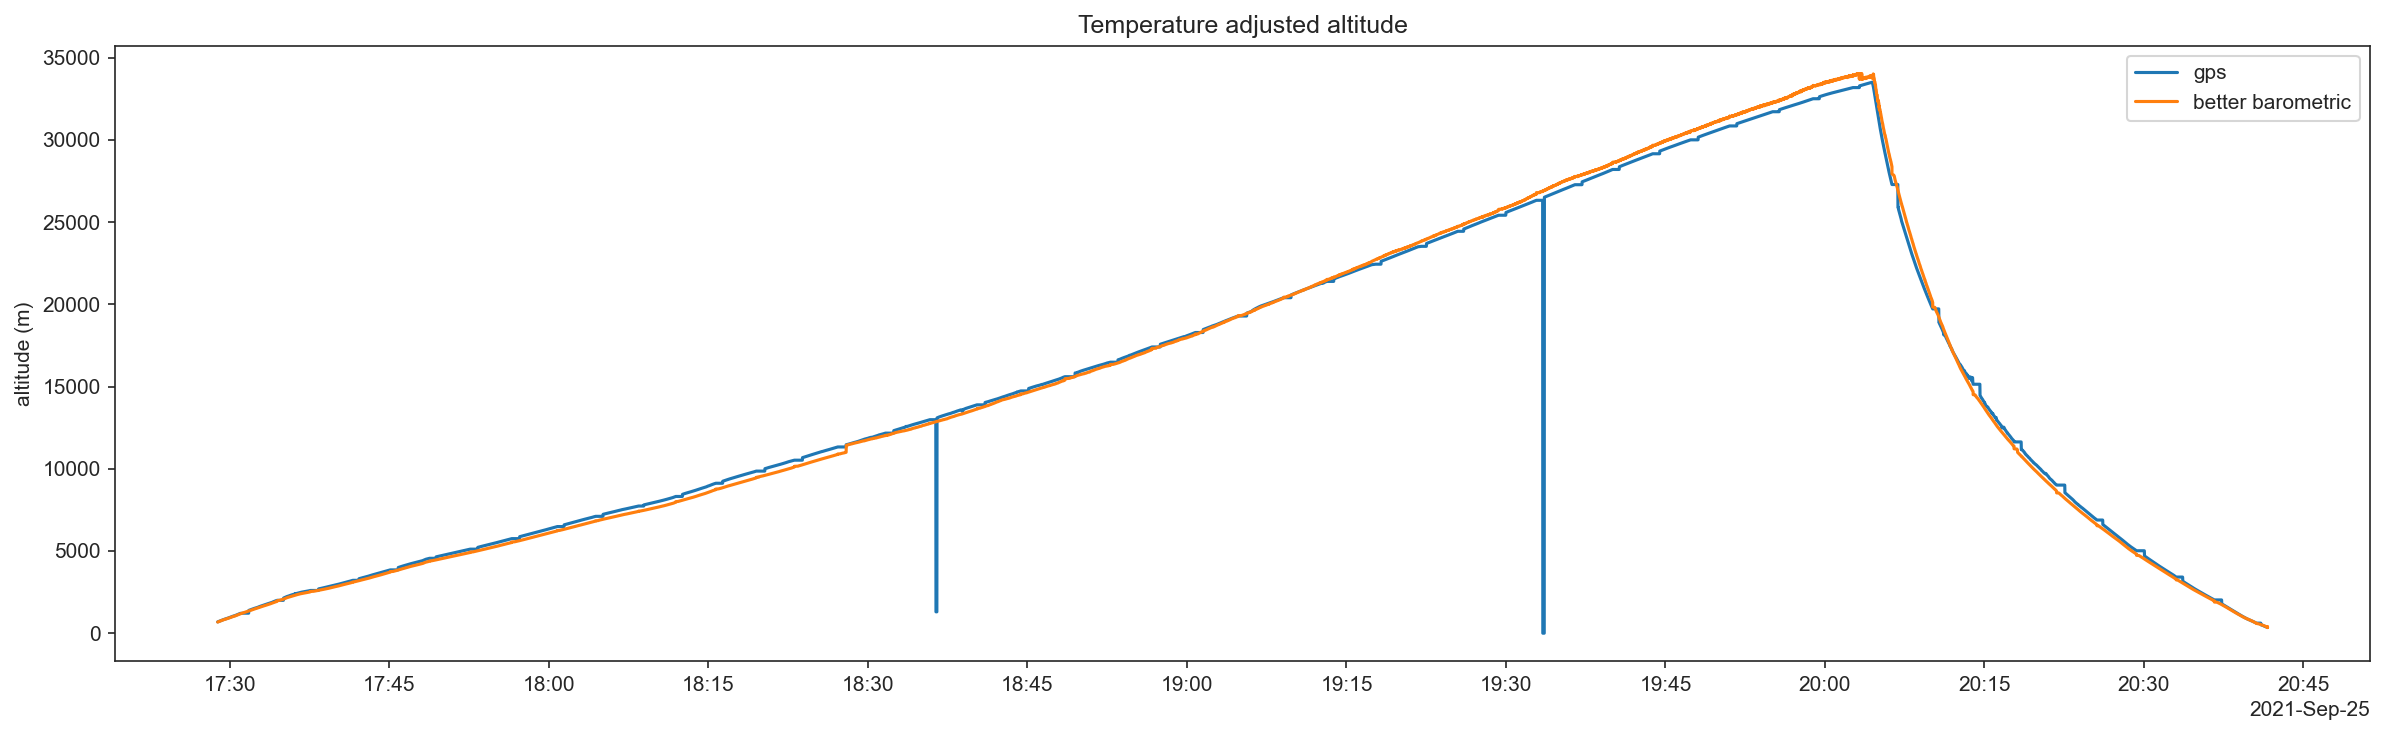

In [30]:
mission_data['blended_altitude_m'] = calc_altitude_blended(mission_data['pressure_Pa'], mission_data['temperature_C'])
ax = pretty_plots()
ax.plot(mission_data[['gps_altitude_m', 'blended_altitude_m']])
ax.set_ylabel("altitude (m)")
ax.legend(["gps", "better barometric"]);
ax.set_title("Temperature adjusted altitude")

difference = mission_data["gps_altitude_m"] - mission_data["blended_altitude_m"]
print(f"Maximum altitude discrepency: {difference.max():.0f} meters")

## Smoothing noise

A reasonable question may be: Why bother having two sources of altitude at all? Well, other than because I could, I was primarily thinking to use the barometric pressure as a back up in case the GPS went out. Turns out, that wasn't a worry - we maintained a strong signal lock throughout the entire journey.

The other reason is that I had noticed during testing that our GPS readings were accurate but often imprecise. Even sitting still, the GPS will report altitude differences in dozens of meters. The barometer, however, was generally very precise.  Together, the two sources of altitude could be used to create an an accurate _and_ precise reading.

Let's see if that holds on this flight...

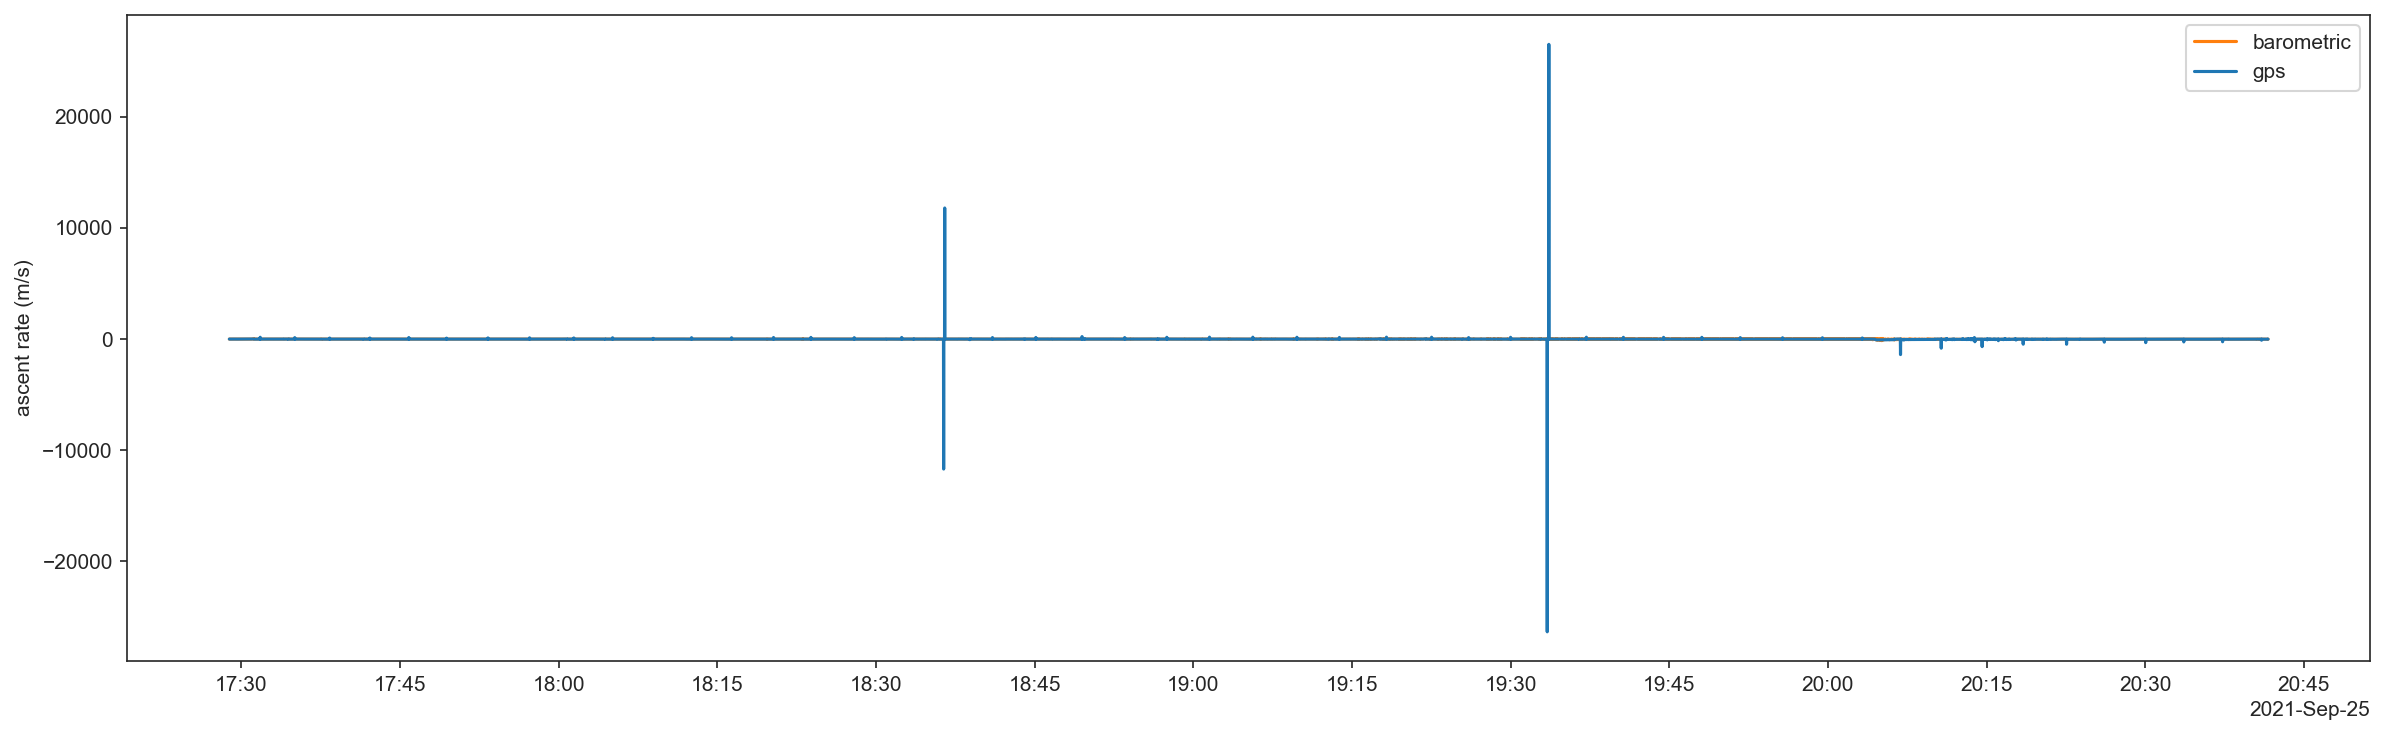

In [32]:
gps_ascent_rate = mission_data['gps_altitude_m'].diff()
pressure_ascent_rate = mission_data['pressure_altitude_m'].diff()

ax = pretty_plots()
ax.plot(pressure_ascent_rate, color="C1")
ax.plot(gps_ascent_rate, color="C0")
ax.legend(["barometric", "gps"])
ax.set_ylabel("ascent rate (m/s)");

Alright, what the heck! Other than some obvious outliers and some noise early in the ascent phase, it seems that the GPS altitude is much more precise over this run, especially as we get into the stratosphere.

Let's take a look at the underlying data: the barometric pressure. Maybe our barometer doesn't work so well at low pressure.

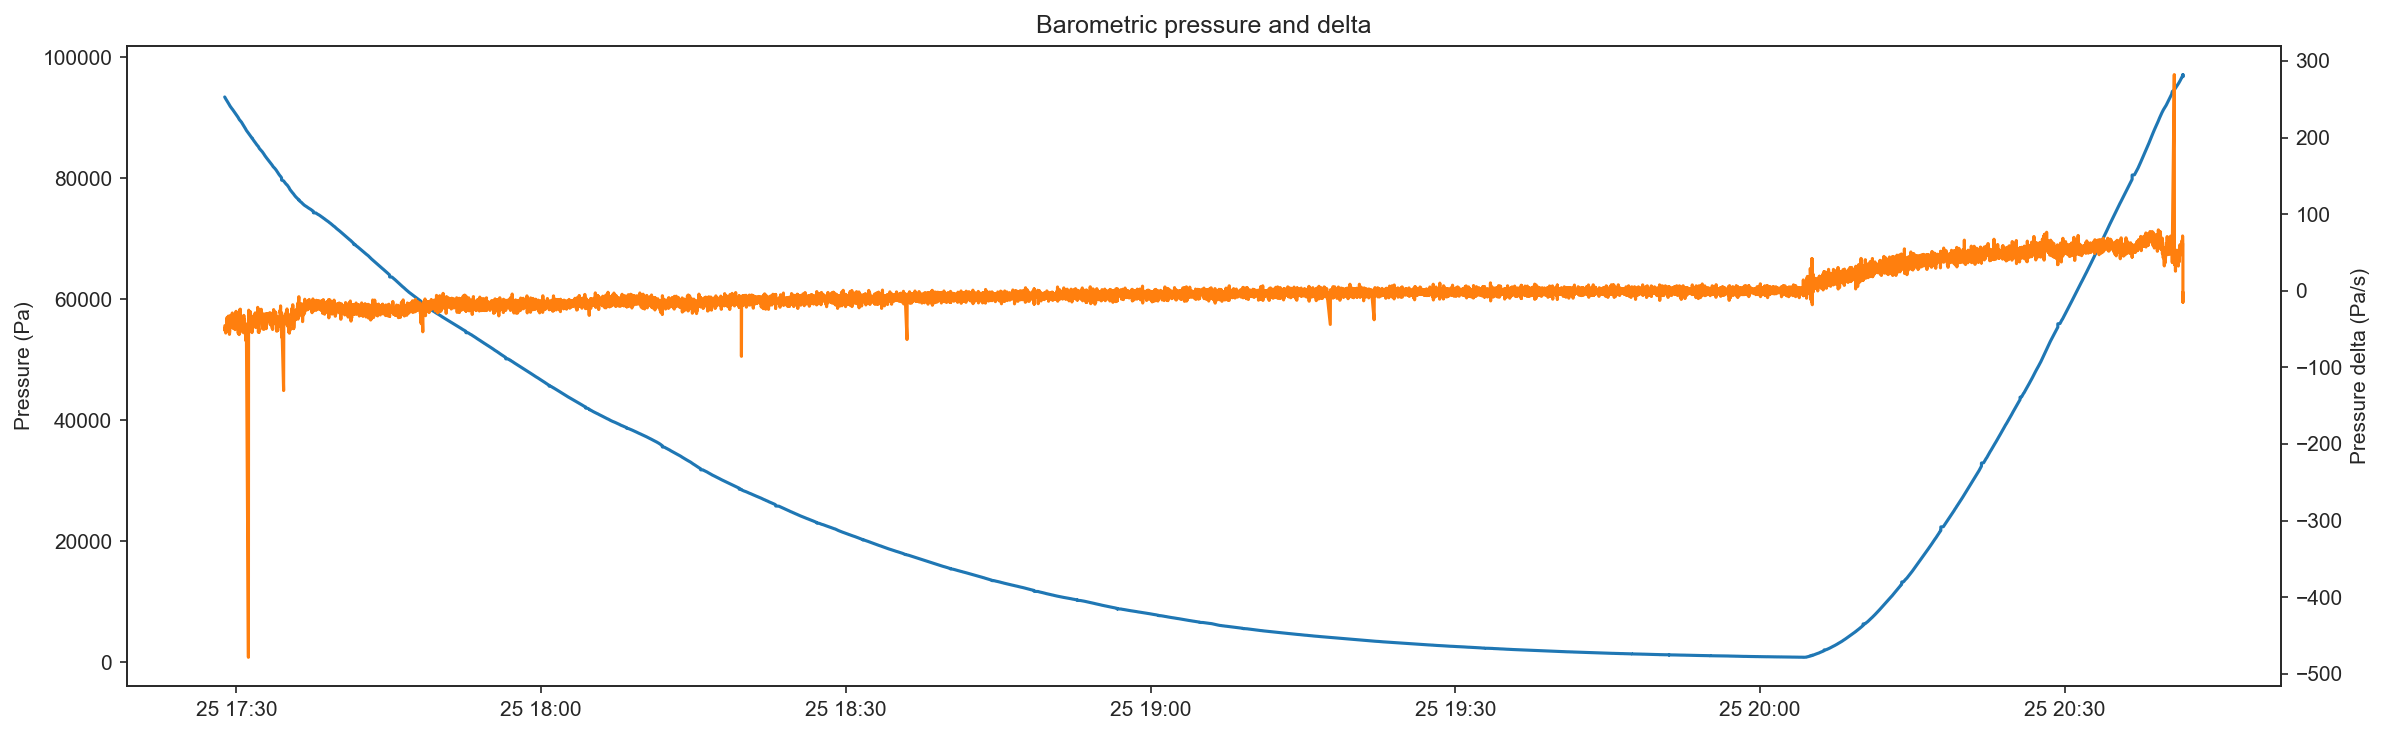

In [33]:
ax = pretty_plots()
ax.plot(mission_data['pressure_Pa'])
ax.set_ylabel("Pressure (Pa)")

ax2 = ax.twinx()
ax2.plot(mission_data['pressure_Pa'].diff(), color="C1")
ax2.set_ylabel("Pressure delta (Pa/s)")

ax.set_title("Barometric pressure and delta");

This seems reasonable enough, apart from noise as our balloon was plummeting through the troposphere. So what's going on?

After some thought, it occured to me that the formula from pressure to altitude is logarithmic! So, a small error in pressure will translate to a larger error as pressure decreases. And this is exactly what we're seeing above.

## Smoothing the altitude

Now, in order to smooth the noise in our altitude reading, I am going to apply an exponential weighted average (EWM) and then combine both the GPS and pressure readings together to get a blend.

The first step is to find an alpha parameter for our EWM that looks suitable. The alpha parameter describes how much weight to apply to the most recent data point compared to the previous data points. An alpha of 1.0 applies no smoothing.

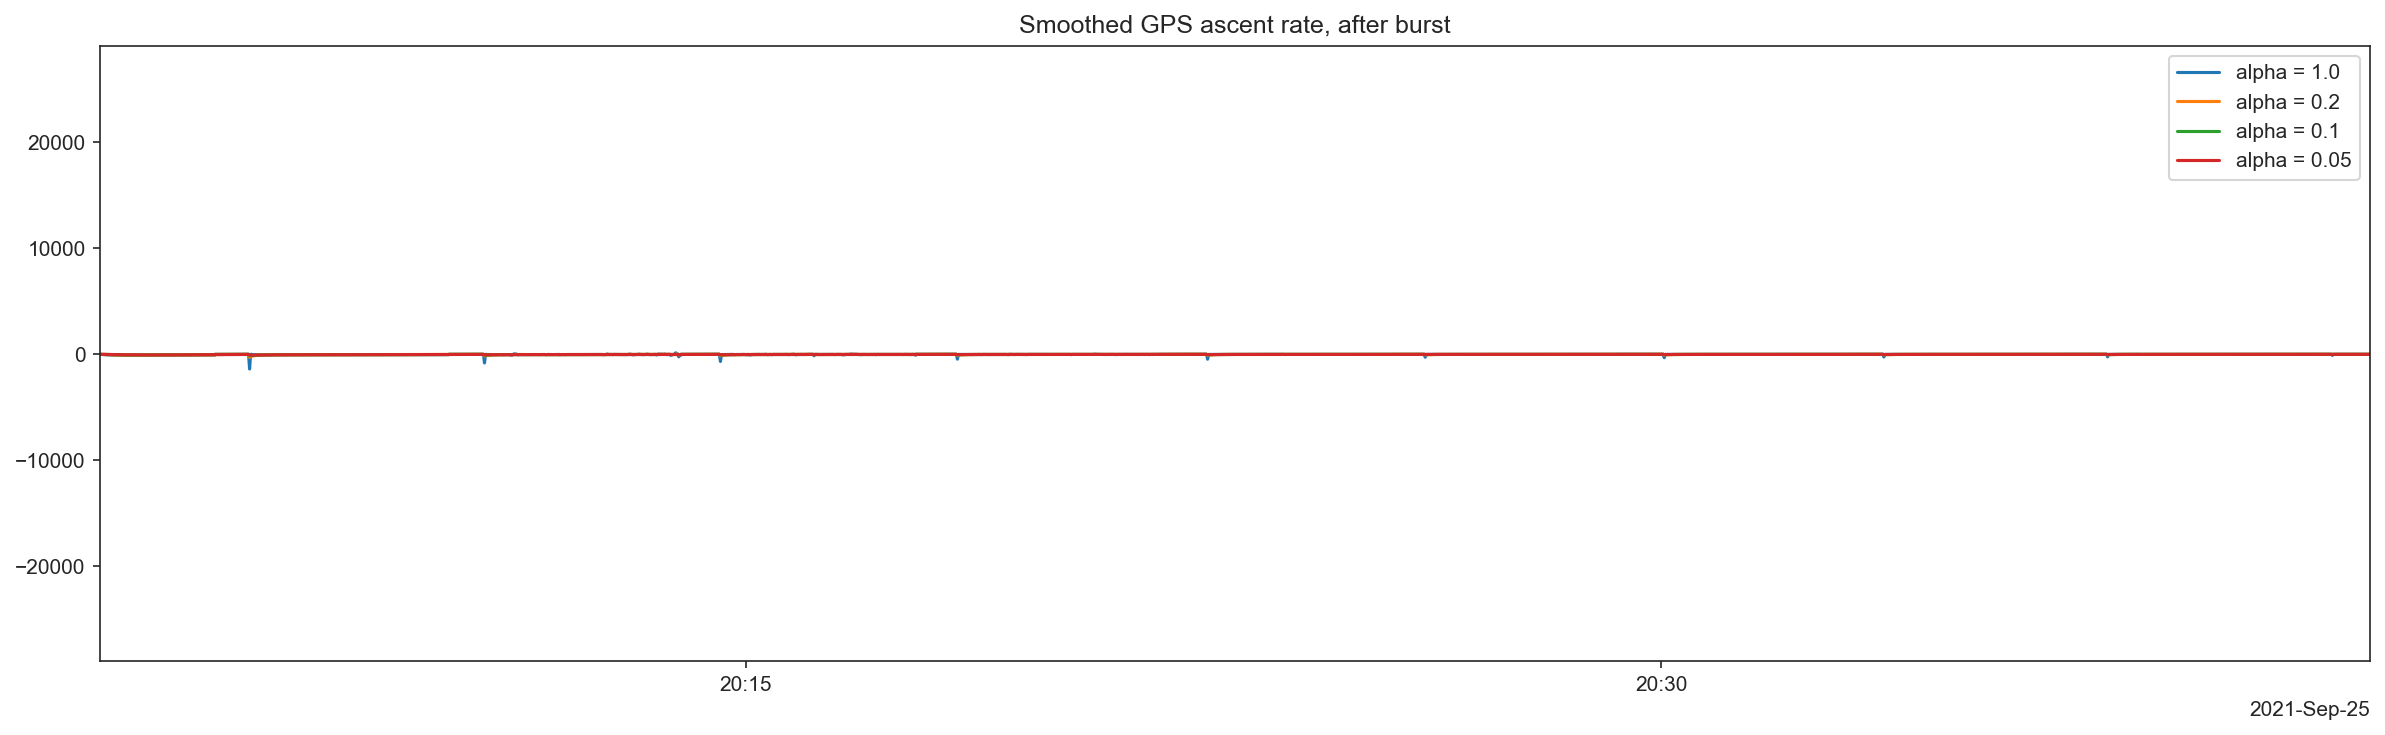

In [34]:
ax = pretty_plots()
ax.set_xlim(burst_time, landing_time)

for alpha in [1.0, 0.2, 0.1, 0.05]:
    smoothed_gps_data = mission_data['gps_altitude_m'].ewm(alpha=alpha).mean()
    ax.plot(smoothed_gps_data.diff(), label="alpha = {}".format(alpha))

ax.set_title("Smoothed GPS ascent rate, after burst")
ax.legend();

For the GPS altitude, with its spurious outliers, applying an aggressive smoothing looks good, but anything much higher than 0.2 loses the detail during the sudden deceleration phase of the descent (when the balloon pops and starts rocketing through the stratosphere).

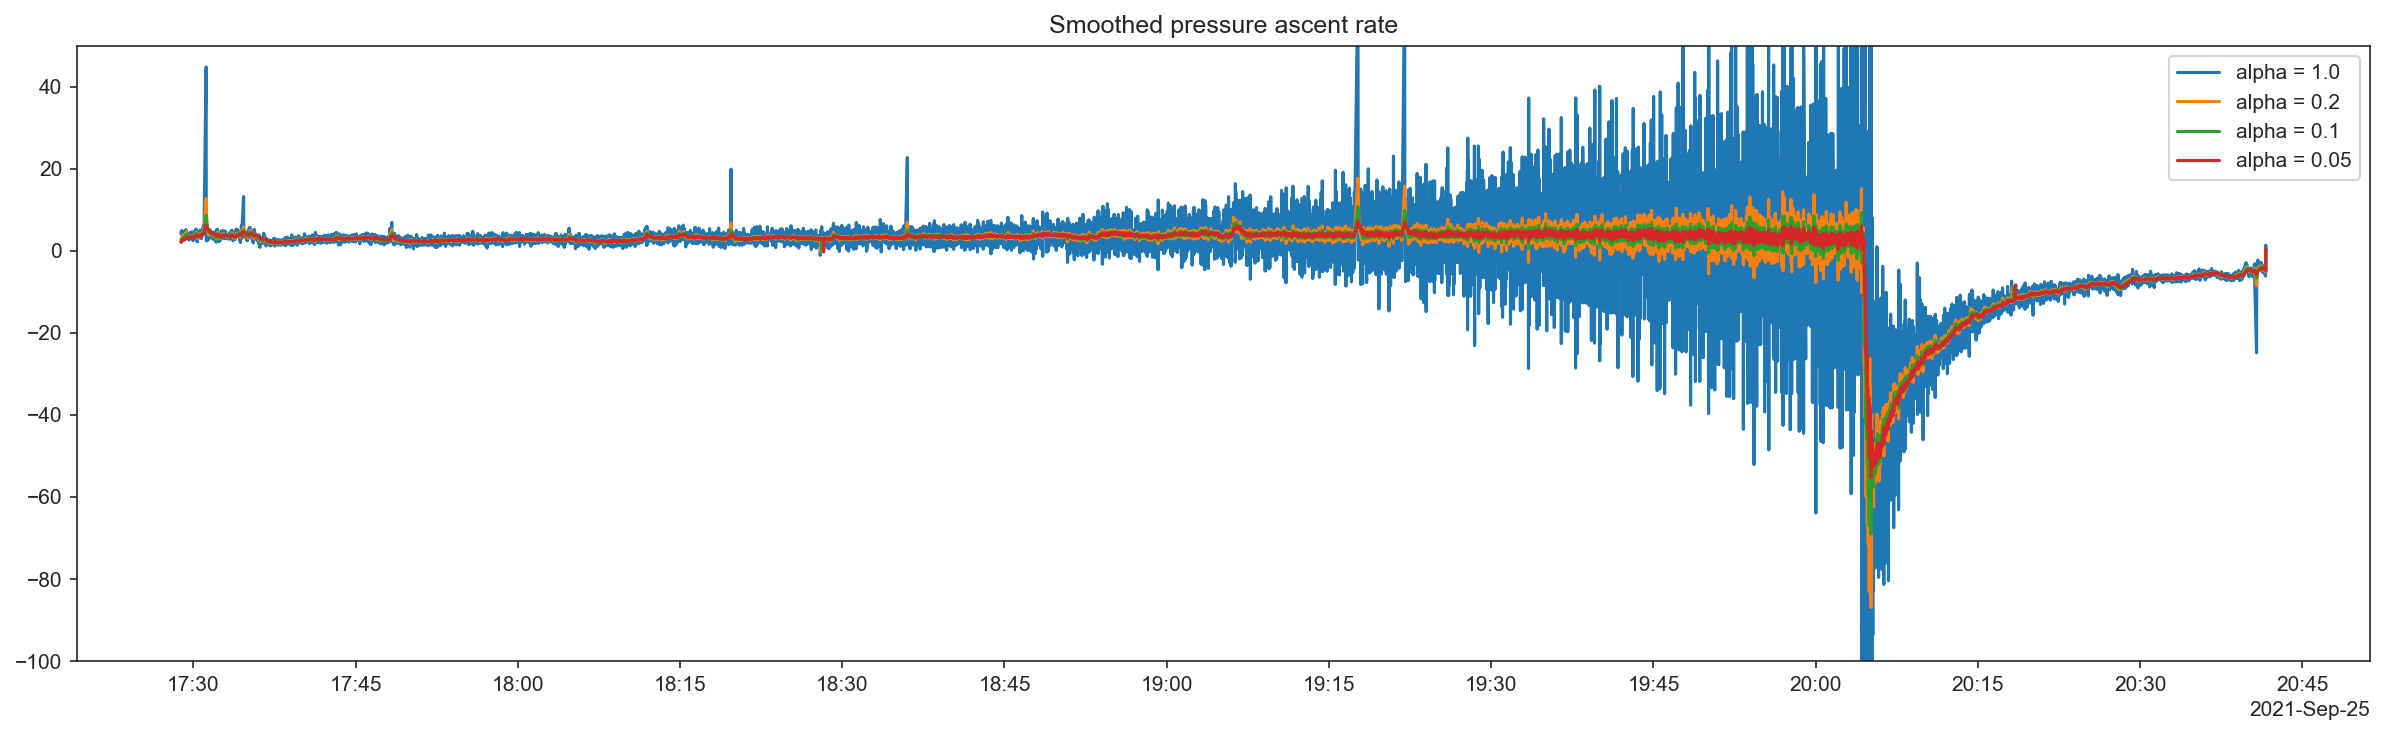

In [35]:
ax = pretty_plots()
ax.set_ylim(-100, 50)

for alpha in [1.0, 0.2, 0.1, 0.05]:
    smoothed_pressure = mission_data['pressure_Pa'].ewm(alpha=alpha).mean()
    smoothed_pressure_altitude = smoothed_pressure.apply(calc_altitude)
    ax.plot(smoothed_pressure_altitude.diff(), label="alpha = {}".format(alpha))
    
ax.set_title("Smoothed pressure ascent rate")
ax.legend();

The noise in the barometric pressure appears much more normally distributed than the GPS (which, as an analog vs digtal device, makes sense), so smoothing seems to work incredibly well here.  Even aggressive values of alpha seem to track the trend very well, with a notable exception of the balloon burst.  I'll choose an alpha of 0.1 here.

In [36]:
mission_data['smoothed_gps_altitude_m'] = mission_data['gps_altitude_m'].ewm(alpha=0.2).mean()
mission_data['smoothed_pressure_Pa'] = mission_data['pressure_Pa'].ewm(alpha=0.1).mean()
mission_data['smoothed_pressure_altitude_m'] = calc_altitude_blended(mission_data['smoothed_pressure_Pa'], mission_data['temperature_C'])

weight = 0.5
mission_data['altitude_m'] = \
    (mission_data['smoothed_gps_altitude_m'] * weight) + \
    (mission_data['smoothed_pressure_altitude_m'] * (1-weight))

/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/142227778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mission_data['smoothed_gps_altitude_m'] = mission_data['gps_altitude_m'].ewm(alpha=0.2).mean()
/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/142227778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mission_data['smoothed_pressure_Pa'] = mission_data['pressure_Pa'].ewm(alpha=0.1).mean()
/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/142227778

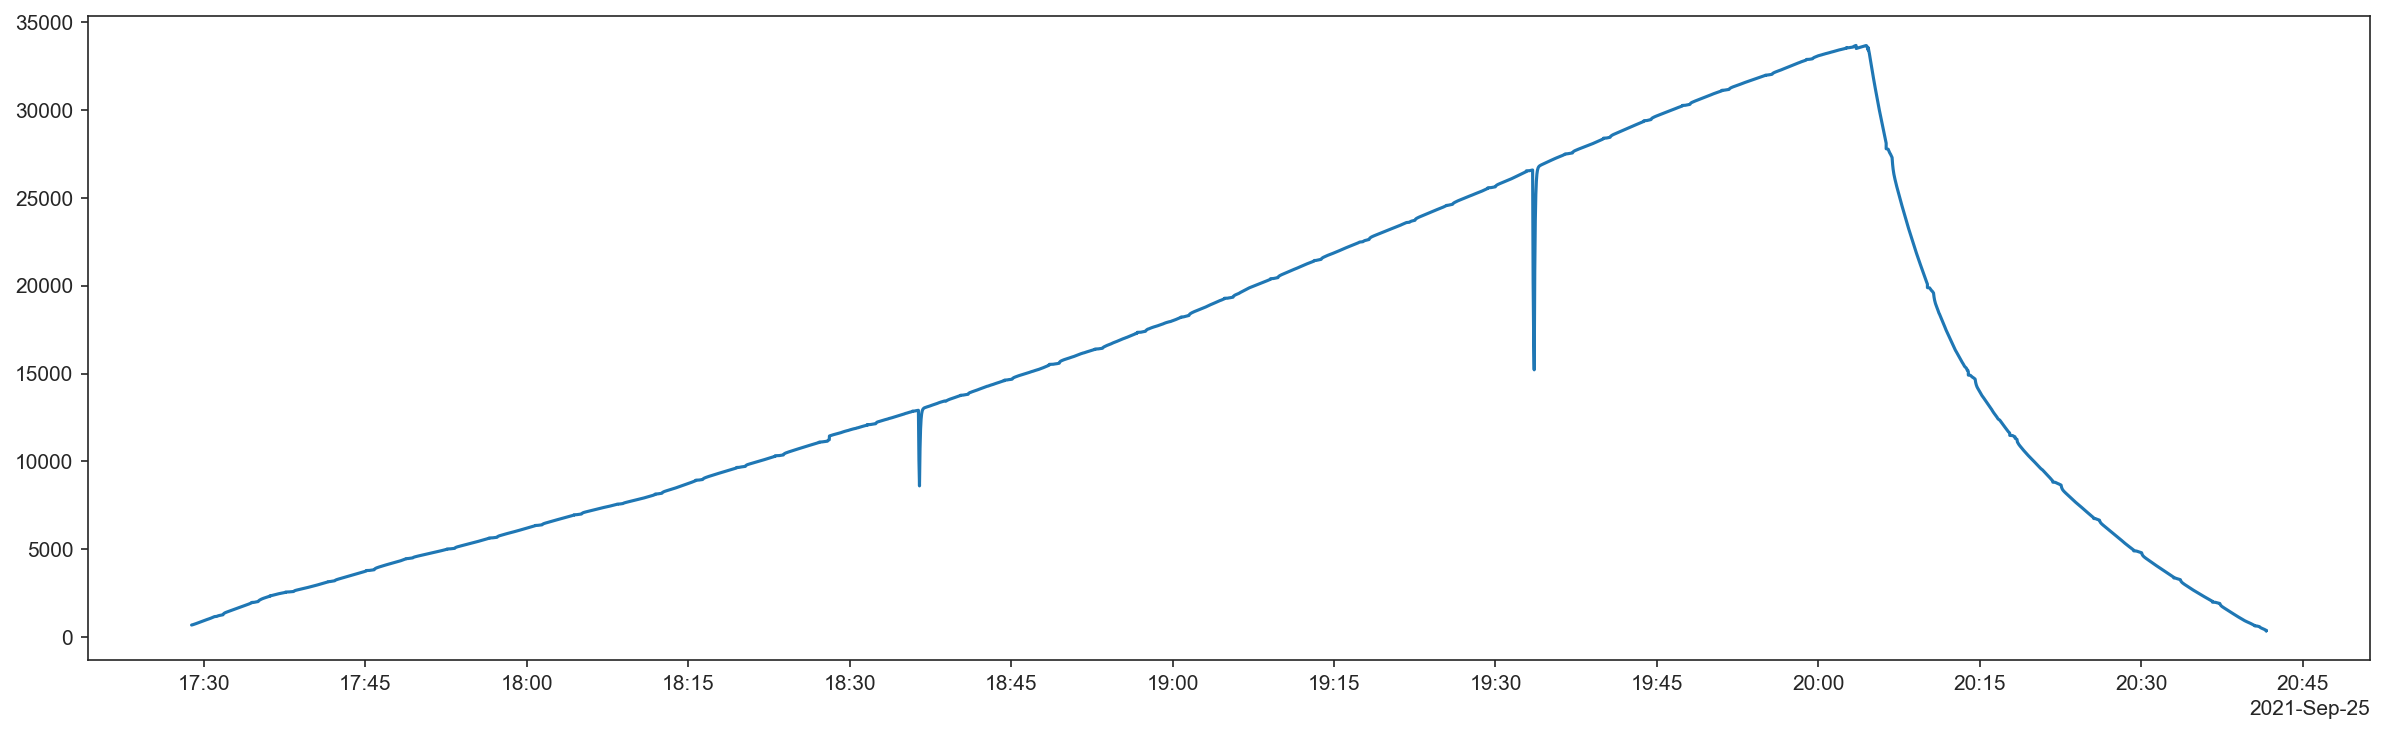

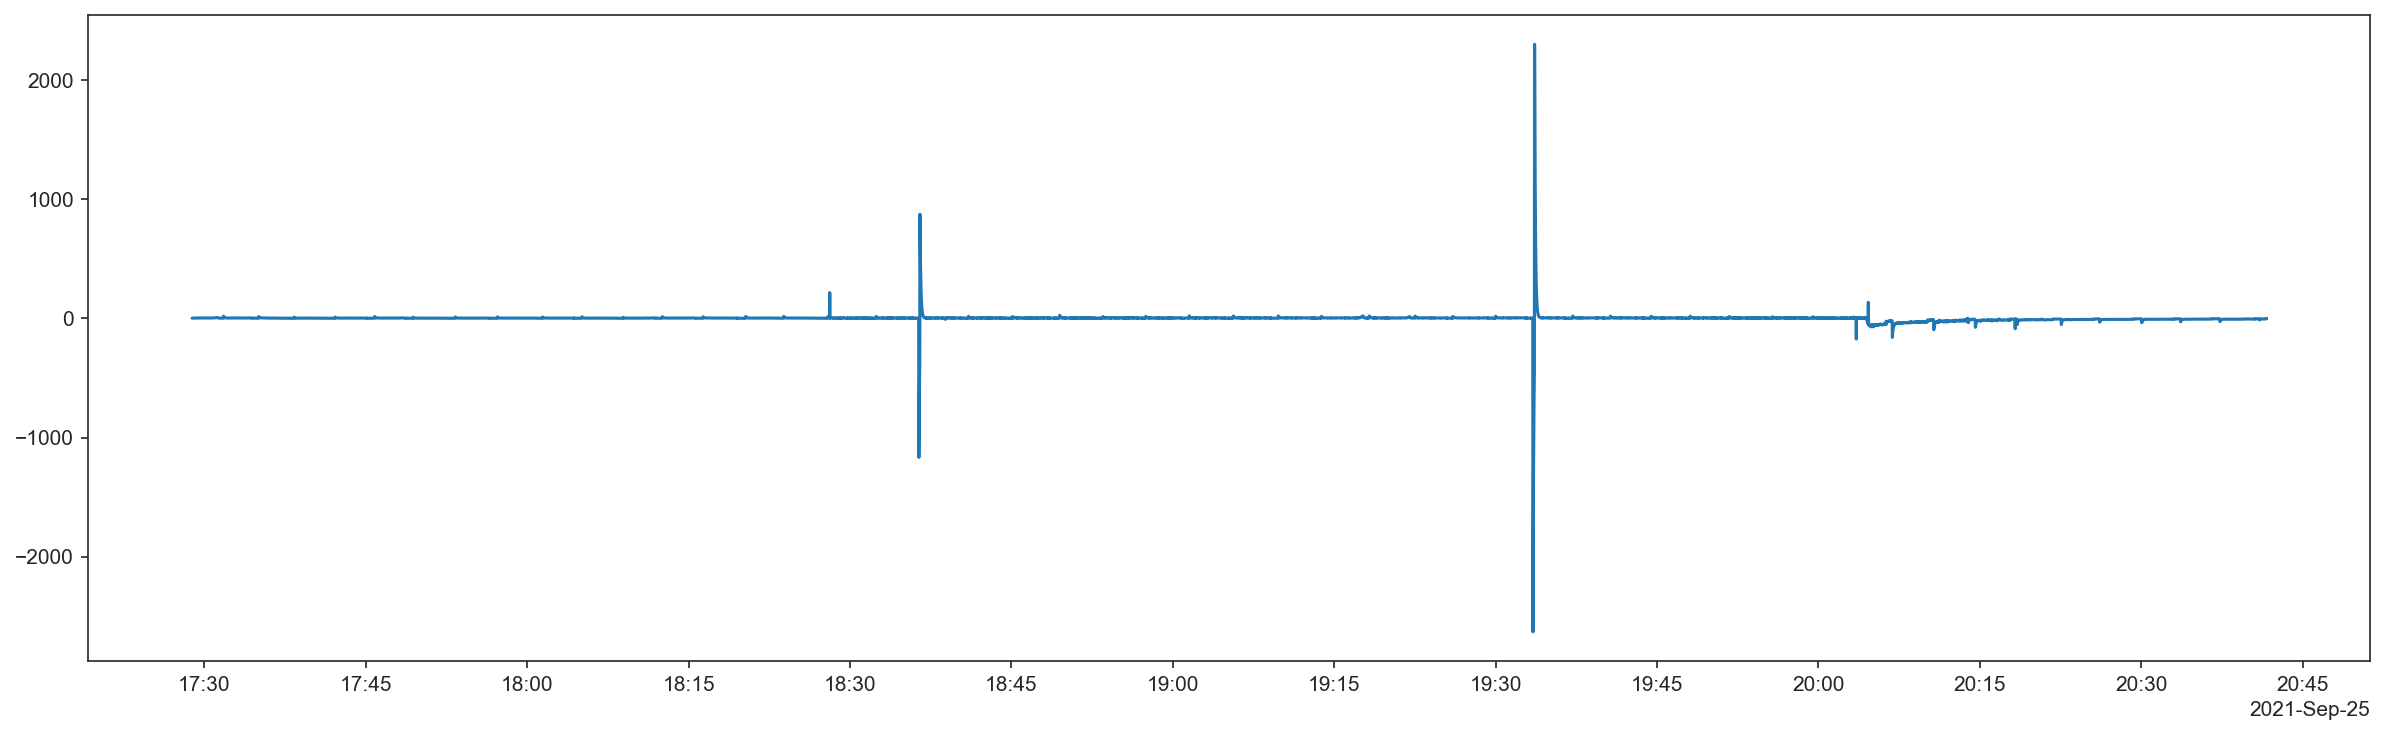

In [37]:
ax = pretty_plots()
ax.plot(mission_data['altitude_m'])

ax = pretty_plots()
ax.plot(mission_data['altitude_m'].diff());

## Altitude statistics

Finally, we can now compute some interesting altitude statistics and use them to answer some questions about our mission.

In [38]:
burst_altitude_index = np.argmax(mission_data['altitude_m'])
burst_altitude_m = mission_data['altitude_m'].max()
burst_altitude_ft = burst_altitude_m / 0.305

print("Burst altitude: {0:0.1f} meters ({1:0.1f} feet)".format(burst_altitude_m, burst_altitude_ft))

Burst altitude: 33678.2 meters (110420.3 feet)


In [39]:
ascent_rate = mission_data['altitude_m'].diff()

# We have a large discontinuity in our smoothed altitude due to sensor noise,
# so I'm going to clip that value from the data.
second_highest_ascent_rate = ascent_rate.nlargest(2)[-1]
mission_data['ascent_rate_mps'] = ascent_rate.clip(upper=second_highest_ascent_rate)

ascent_phase = mission_data[mission_data.index < burst_time].copy()
descent_phase = mission_data[mission_data.index > burst_time].copy()

print("Maximum ascent rate: {0:0.2f} m/s".format(ascent_phase['ascent_rate_mps'].max()))
print("Average ascent rate: {0:0.2f} m/s".format(ascent_phase['ascent_rate_mps'].mean()))
print()
print("Maximum descent rate: {0:0.2f} m/s".format(descent_phase['ascent_rate_mps'].min()*-1))
print("Average descent rate: {0:0.2f} m/s".format(descent_phase['ascent_rate_mps'].mean()*-1))

Maximum ascent rate: 1841.64 m/s
Average ascent rate: 3.52 m/s

Maximum descent rate: 158.79 m/s
Average descent rate: 4.46 m/s


/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/2190321210.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mission_data['ascent_rate_mps'] = ascent_rate.clip(upper=second_highest_ascent_rate)


Max speed: 200.70 m/s


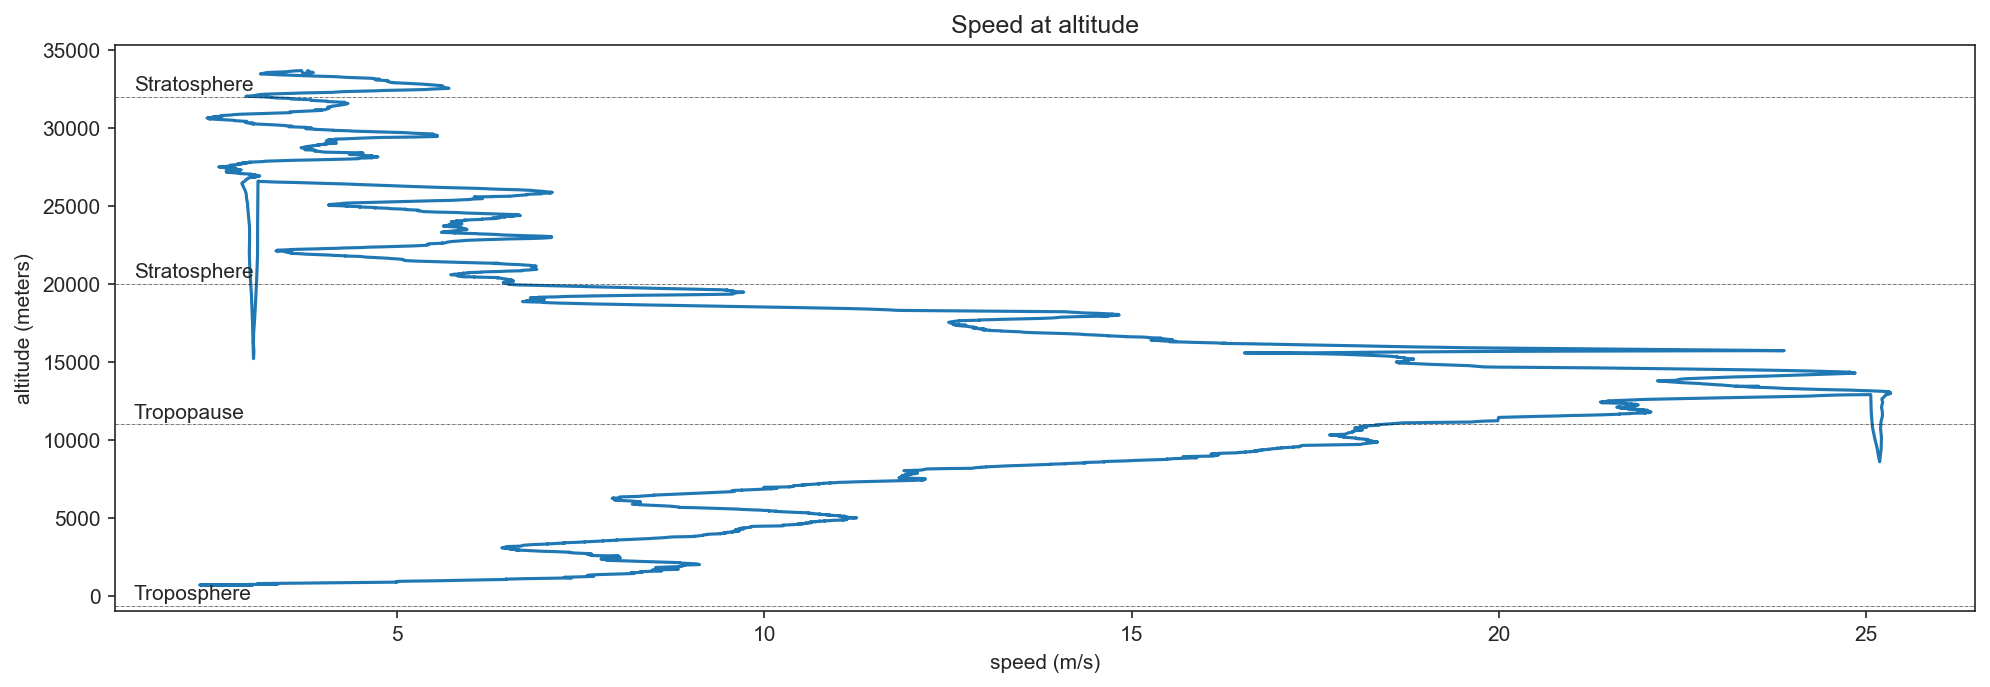

In [40]:
fig, ax = plt.subplots()

ax.plot(ascent_phase['speed_mps'].ewm(alpha=0.01).mean(), ascent_phase['altitude_m'])
annotate_layers(ax, label=True, max_layer=4)
ax.set_title("Speed at altitude")
ax.set_xlabel("speed (m/s)")
ax.set_ylabel("altitude (meters)")

max_speed = mission_data['speed_mps'].max()
print(f"Max speed: {max_speed:0.2f} m/s")

From the above data, we can see why our balloon travelled so far east from its predicted flight path. Our original estimated ascent rate was 4.9 m/s, but since we ran out of helium before hitting our target lift, our actual ascent rate averaged only 3.9 m/s.  This caused our balloon to drift through the jet stream for a longer period of time, where it was being blown around at a brisk **35 m/s (~80 mph)**!

## Parachute drag

One of our questions is why our balloon descended as quickly as it did.  We were using a 3' High Altitude Balloon Parachute from [the-rocketman.com](https://the-rocketman.com/recovery-html/).  Our payload weighed 1325 grams (2.9 lbs).  According to the parachute's specs, this should have put us a little over 20 feet per second **(6.1 m/s)** at 1 atmosphere.

Initial tests made us concerned that the descent rate was too high, so we conducted an experiment where we tossed the parachute off the Fremont bridge.  From analyzing the footage in slow motion, we were able to time the fall and measured a descent rate of between 6-7 m/s. A little high, but within our specs.

What did we measure?

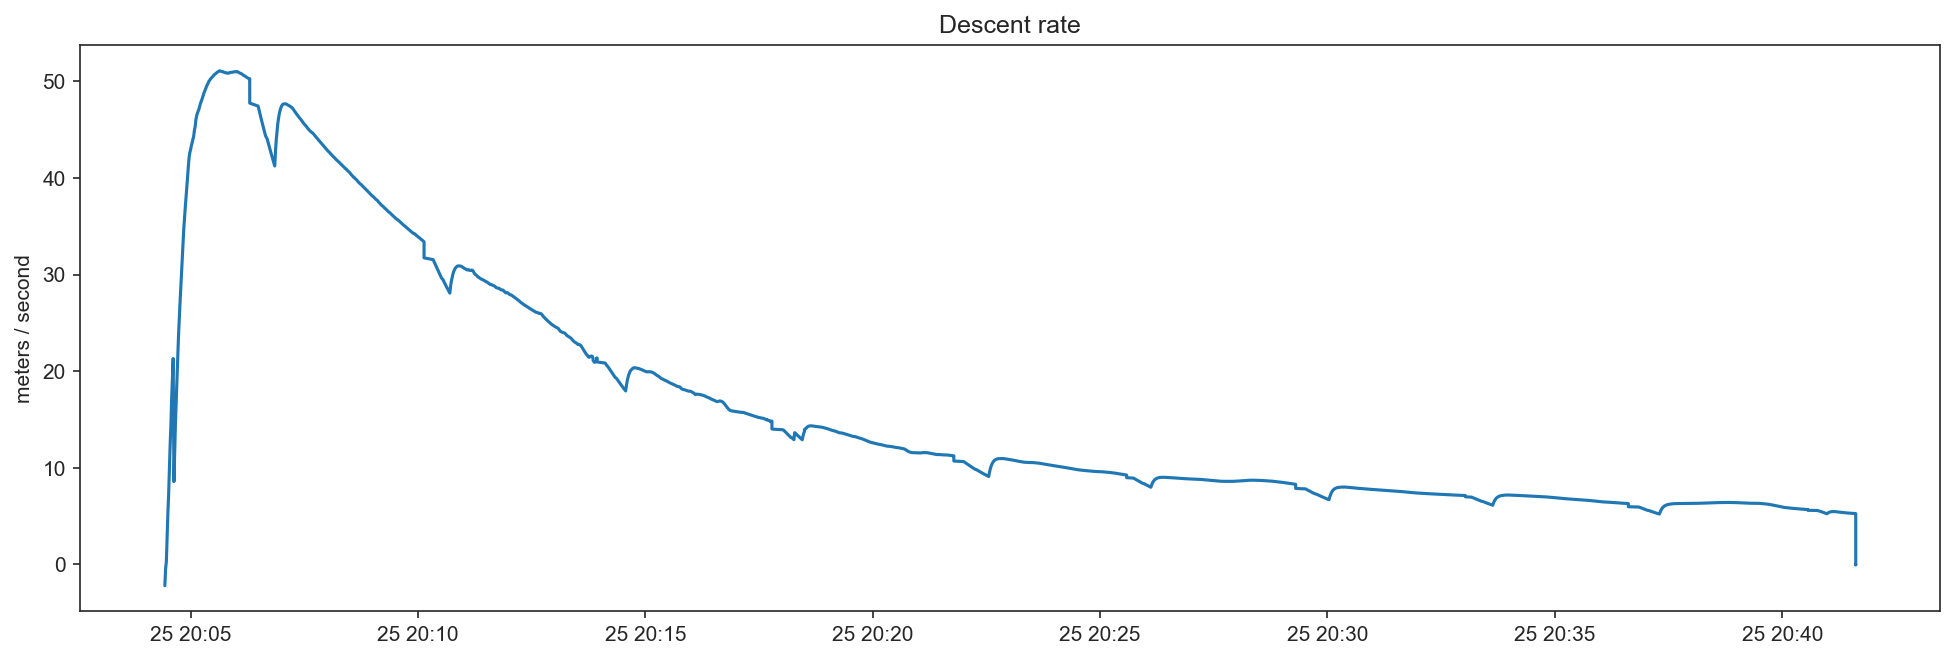

In [41]:
fig, ax = plt.subplots()

smoothed_descent_rate = descent_phase['ascent_rate_mps'].ewm(alpha=0.01).mean() * -1

ax.plot(smoothed_descent_rate)
ax.set_title("Descent rate")
ax.set_ylabel("meters / second")
plt.show()

In [42]:
close_to_ground = descent_phase[descent_phase['altitude_m'] < 5000]
descent_rate_close_to_ground = close_to_ground['ascent_rate_mps'].mean() * -1

print("Average descent while under 5000 m: {0:0.2f} m/s".format(descent_rate_close_to_ground))

Average descent while under 5000 m: 0.77 m/s


As we can see, the balloon starts to plummet at a whopping 50 m/s in the stratosphere and then starts to decelerate as the atmospheric pressure increases, eventually tapering off to **~11 m/s** before hitting the ground.  That's almost twice as fast as we predicted. What went wrong?

### Aside: On safety of a falling object

In model rocketry, a typical safe descent rate is usually in the 4-5 m/s range.  For HAB, it seems that a slightly higher 5-8 m/s is common. Is there a way to calculate a safe descent rate?

According to the Dropped Object Prevention Scheme ([DROPS](https://www.dropsonline.org/resources-and-guidance/drops-calculator/)), a blunt object achieving a kinetic energy of **40 Joules** or higher is likely to result in a "recordable incident" requiring more than minor first aid care.

The energy of a falling object can be calculated as $KE = \frac{1}{2}mv^2$:

In [43]:
def kinetic_energy_J(mass_kg, velocity_mps):
    return 0.5 * mass_kg * math.pow(velocity_mps, 2)

predicted_energy_J = kinetic_energy_J(payload_weight_g/1000, 6.1)
actual_energy_J = kinetic_energy_J(payload_weight_g/1000, descent_rate_close_to_ground)

print(f"The energy imparted by our falling balloon was predicted to"
      + f"be {predicted_energy_J:0.1f} J but was actually {actual_energy_J:0.1f} J.")

The energy imparted by our falling balloon was predicted tobe 24.7 J but was actually 0.4 J.


**81.5 J** is higher than the "40 Joule Rule" and likely to cause injury, so it is critical that we fix this issue before a subsequent flight.

Note: [The paper](https://www.tandfonline.com/doi/pdf/10.1080/01446193.2016.1274418) that the "40 Joule Rule" appears to be based off of seems to indicate that the rule is rather conservative and that the area the force is applied across is a factor in injuries.  I suspect if our balloon had fallen on an innocent bystander that it would have been painful but probably not serious.  However, I would much rather be safe than sorry!

### Terminal Velocity

An object in free fall accelerates under the force of gravity until it reaches an equilibrium where the force of drag balances the force of gravity.  This is known as [terminal velocity](https://en.wikipedia.org/wiki/Terminal_velocity) and can be rather easily derived:

$F_g = F_D$

$mg = \frac{1}{2}\rho v^2AC_d$

$V_t = \sqrt{\frac{2mg}{\rho AC_d}}$

We can calculate the density of air, $\rho$, from the ideal gas law: $\rho = \frac{P}{RT}$ where $R$ is the specific gas constant for air (we're using dry air for simplicity).

In [44]:
def calc_terminal_velocity(density, mass_kg, area_m2, coefficient_drag):
    return math.sqrt((2 * mass_kg * gravitational_acceleration)/(density * area_m2, coefficient_drag))

def calc_density(pressure_Pa, temperature_C):
    temperature_K = temperature_C + 273.15
    return pressure_Pa / (gas_constant_dry_air * temperature_K)

calc_terminal_velocity = np.vectorize(calc_terminal_velocity)
calc_density = np.vectorize(calc_density)

density = calc_density(descent_phase['pressure_Pa'], descent_phase['temperature_C'])
# Using a 3' rocketman parachute with approx. Cd of 0.8
#WIP
# predicted_terminal_velocity = calc_terminal_velocity(density, 1.325, 0.9144, 0.8)

# ax = pretty_plots()
# ax.plot(predicted_terminal_velocity)
# ax.set_title("Pressure")
# ax.set_ylabel("kg/m^3")
# plt.show()

## Camera Shutoff

Our final question: why did the camera shut off at 55 minutes into the flight?

Minium voltage 4.13V


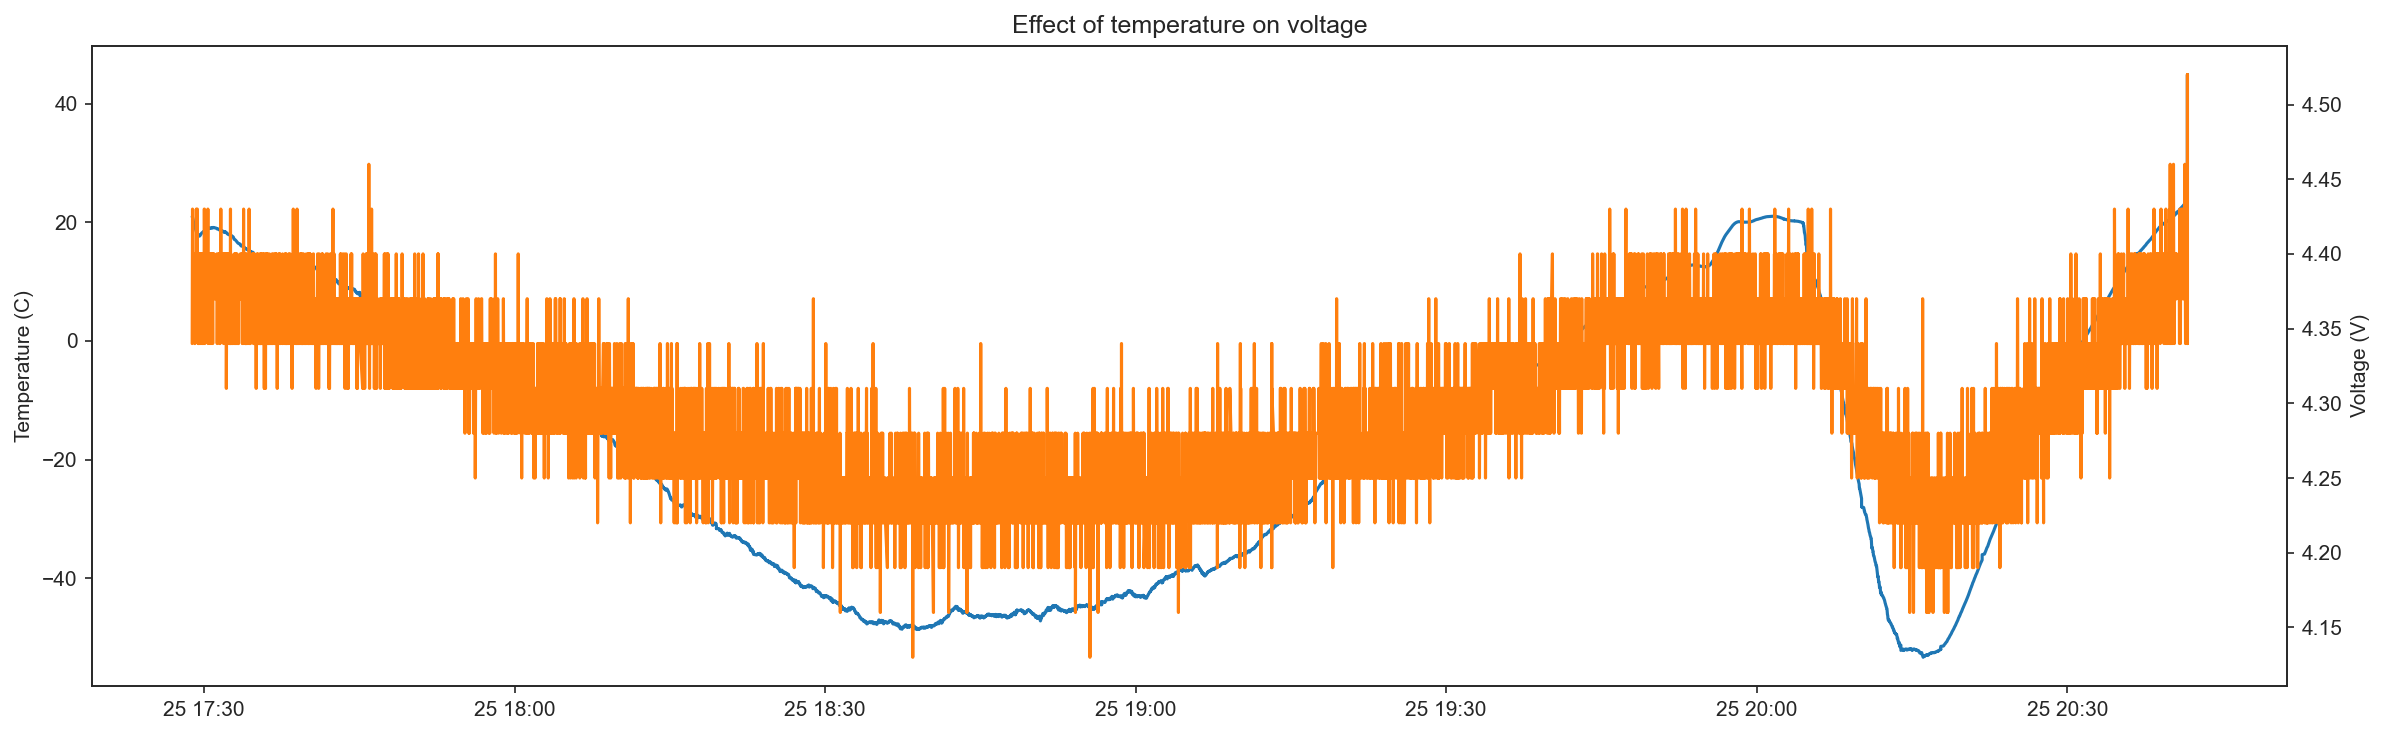

In [45]:
ax = pretty_plots()
ax.plot(mission_data['temperature_C'])
ax2 = ax.twinx()
ax2.plot(mission_data['voltage'], color='C1')
ax.set_title("Effect of temperature on voltage")
ax.set_ylabel("Temperature (C)")
ax2.set_ylabel("Voltage (V)")

print(f"Minium voltage {mission_data['voltage'].min()}V")

The above chart shows a very strong correlation between the voltage output on the tracking computer and the temperature, reaching a minimum voltage of 6V. We knew before the mission that temperature has a negative impact on Li-ion batteries and bought batteries that were specifically advertised to work in low temperatures.

However, even with this caution, we suspect that the single 16850 battery used as an external battery for the GoPro likely dropped below 3V and probably caused the camera to shut off.

Another observation from this chart are the regular spikes of low voltage, which are caused by the APRS transmitter sending a packet every 60 seconds (+/- 10 seconds).

In [46]:
# Write the missison data back out to a csv file.
mission_data.to_csv(directory + '/clean-data.csv')